# Data preparation

### Dataset creation

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [2]:
df_docs = pd.read_parquet("/home/azureuser/cloudfiles/code/Users/rduffau/data/docs_with_pages_4K.parquet")

In [3]:
df_evs = pd.read_parquet("/home/azureuser/cloudfiles/code/Users/rduffau/data/evs_qa_dataset.parquet")

In [4]:
df_joined = pd.merge(df_evs, df_docs, on="idDocument")
del df_evs
del df_docs
import gc
gc.collect()

0

In [5]:
df_joined['textStr'] = [','.join(map(str, l)) for l in df_joined['textPerPage']]

In [6]:
df_joined['wordCount'] = df_joined['textStr'].apply(lambda x: len(x.split()))
df_joined['analystSourceExists'] = df_joined.analystSource.apply(lambda x: 0 if x is None else 1)
df_joined["percentQuest"] = df_joined.apply(lambda x: 1 if "percentage" in x["textQuestion"].lower() else 0, axis=1)
df_joined["cdpQuest"] = df_joined.apply(lambda x: 1 if "cdp" in x["textQuestion"].lower() else 0, axis=1)
df_joined["certificateQuest"] = df_joined.apply(lambda x: 1 if "certification" in x["textQuestion"].lower() else 0, axis=1)

### Gold-labelled Page verification

In [7]:
def removeFakePgNbrs(pageNbr):
    pageNbr = pageNbr.lower().replace("l0", "").replace("l-1", "").replace("l1", "")
    return pageNbr
    

def removeYears(pageNbr):
    l = re.findall(r'\d{4}', pageNbr)
    if len(l)!=0:
        for s in l:
            pageNbr = pageNbr.replace(s, '')
    return pageNbr


def getPagesWhenRange(pageNbr):
    pgs = re.search(r'\d+\s*-\s*\d+', pageNbr).group().split("-")
    start = int(pgs[0])-1
    end = int(pgs[1])
    range_nbr = list(range(start, end))
    others = re.findall(r'\d+', pageNbr)
    others = [int(i)-1 for i in others]
    all_pgs = range_nbr + others
    return list(set(all_pgs))
    

def cleanPageNbr(pageNbr):
    """
    :param pageNbr: non-standard text introduced by analyst
    :return: list of string : cleaned page numbers
    """
    pageNbr = str(pageNbr)
    pageNbr = removeFakePgNbrs(pageNbr)
    pageNbr = removeYears(pageNbr)
    if re.findall(r'\d+\s*-\s*\d+', pageNbr):
        pages = getPagesWhenRange(pageNbr)
        return pages 
    pages = re.findall(r'\d+', pageNbr)
    pages = [int(i)-1 for i in pages if i!= 0]
    return list(set(pages))

In [8]:
df_joined['answerPage'] = df_joined.apply(lambda x: cleanPageNbr(x['analystSource']), axis=1)

In [9]:
df_joined['answerPage'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                20596
[0]                 592
[1]                 211
[6]                 206
[5]                 196
                  ...  
[88, 27, 87]          1
[18, 37]              1
[1, 2, 26, 25]        1
[25, 26, 2, 1]        1
[16, 14]              1
Name: answerPage, Length: 1344, dtype: int64

### Creating shorter dataset for experiments

In [10]:
# Create shorter version of dataset with only useful rows
df_joined_short = df_joined[(df_joined.wordCount > 100) 
                            & (df_joined.wordCount < 100000)
                            & (df_joined.numPages > 1)  & (df_joined.cdOriginalLanguage == "en") 
                            & (df_joined.state == "Approved") & (df_joined.analystSourceExists == 1) 
                            & (df_joined.idQuestionType == 1) & (df_joined.percentQuest == 0)
                            & (df_joined.cdpQuest == 0) & (df_joined.certificateQuest == 0)
                            & (df_joined.answerPage != 'all')]
df_joined_short.reset_index(drop=False, inplace=True)
print("Number of questions-answers: ", len(df_joined_short))
print("Number of passages: ", df_joined_short.wordCount.sum()/100)

Number of questions-answers:  8350
Number of passages:  2159474.94


### Query creation

In [11]:
def extract_optionHelp(optionHelp):
    optionHelp = str(optionHelp)
    result = re.search(r'(?<=The document\(s\) should demonstrate the following: )\s*.*',optionHelp)
    if result:
        result = re.sub(r'(the reporting should cover.*)', '', result.group(0).lower())
        return result
    else:
        return ''
    
def select_query(option_help, option_text, question_text, question_type):
    option_help = extract_optionHelp(str(option_help))
    if len(option_help) != 0:
        query = option_help[:500]
        query_type = 'option_help'
        
    elif question_type == 2:
        query = question_text
        query_type = 'question_text'
    elif len(str(option_text).split()) > 4 and option_text != 'topics other than those mentioned above (please specify)':
        query = str(option_text).lower()
        query_type = 'option_text'
    else:
        query = str(question_text).lower() + ' ' + str(option_text).lower()
        query_type = 'concat_quest_opt'
        
    return (query, query_type)

df_joined_short['query'] = df_joined_short.apply(lambda x: select_query(x['optionHelp'], x['textOption'], x['textQuestion'], x['idQuestionType'])[0], axis=1)
df_joined_short['query_type'] = df_joined_short.apply(lambda x: select_query(x['optionHelp'], x['textOption'], x['textQuestion'], x['idQuestionType'])[1], axis=1)
df_joined_short['query_id'] = df_joined_short.index.values.tolist()

In [12]:
df_joined_short.query_type.value_counts()

option_help         8025
option_text          210
concat_quest_opt     115
Name: query_type, dtype: int64

In [13]:
#Checking that simplication of Option_help worked well
df_joined_short[df_joined_short.query_type == "option_help"]['query'].iloc[6]

'public or internal reporting of consolidated data on energy consumption and greenhouse gas emissions from company operations. '

<AxesSubplot:>

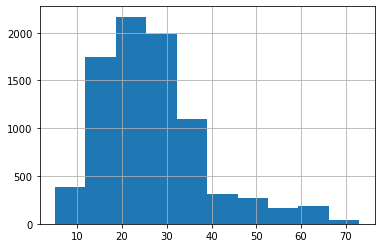

In [14]:
# Checking size of queries (in number of words)
df_joined_short['queryWordCount'] = df_joined_short['query'].apply(lambda x: len(x.split()))
df_joined_short['queryWordCount'].hist()

### Passages creation

In [15]:
# Tokenize and clean page text: split (simpler and faster), Word Tokenizer or TweetTokenizer (much longer to compute)
# Removing urls and html tags doesn't seem to improve results, but can be activated by removing comments below

import re
from math import ceil
#from nltk.tokenize import TweetTokenizer
#import nltk
#nltk.download('punkt')
#from nltk.tokenize import word_tokenize

#tk = TweetTokenizer()

def create_passages(text_list, passage_size):
    """ :param text_list: list of text pages (1 page per list item) 
        :param passage_size: expected size of each passage (recommended: between 100 and 200) 
        :return: list of triplets [page number, passage number in page, passage content]
    """ 
    passages = []
    page_id = 0
    global pass_id
    for text_words in text_list:
#        text_words = re.sub(r'https?://\S+', '', text_words)
#        text_words = re.sub(r'<.*?>', '', text_words)
        text_words = text_words.lower().split()
#        text_words = tk.tokenize(text_words.lower())
#        text_words = word_tokenize(text_words.lower())        
        if len(text_words) % passage_size < 30 and len(text_words) % passage_size > 0:
            passage_size2 = ceil(len(text_words) / ((len(text_words) // passage_size) + 1))
        else:
            passage_size2 = passage_size
        for i in range(0, len(text_words), passage_size2):
            passage = [page_id, pass_id, ' '.join(text_words[i:i+passage_size2])]
            if passage[2] != '':
                passages.append(passage)
                pass_id += 1
        page_id += 1
    return passages

In [16]:
pass_id = 0
df_joined_short['passages'] = df_joined_short['textPerPage'].apply(lambda x: create_passages(x, 100))
df_joined_short

,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,analystSourceExists,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,1,0,0,0,[22],detailed information available on fuel consump...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall..."
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,1,0,0,0,[50],company specific employee awareness programs g...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha..."
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,1,0,0,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha..."
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,1,0,0,0,[20],design of the product with special considerati...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch..."
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,1,0,0,0,[12],environmental impact analysis of the product d...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,32066,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,1,0,0,0,[4],detailed coverage of company's specific health...,option_help,8345,24,"[[0, 2445552, 1 employee handbook 2019], [1, 2..."
8346,32067,18509,2348,Additional leave beyond standard vacation days,Examples of documents to attach: employee hand...,What actions are in place regarding working co...,1,LAB3201_3,1737,LAB3201,...,1,0,0,0,"[2, 3]",provision of additional leave beyond standard ...,option_help,8346,22,"[[0, 2445724, handbook employee], [1, 2445725,..."
8347,32069,18510,2348,Flexible organization of work available to emp...,Examples of documents to attach: standard oper...,What actions are in place regarding working co...,1,LAB3201_4,1737,LAB3201,...,1,0,0,0,[0],provision of flexible working arrangement (eg ...,option_help,8347,33,"[[0, 2445739, page 1 ypsomed holding ag brunnm..."
8348,32070,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,1,0,0,0,[1],detailed coverage of company's specific health...,option_help,8348,24,"[[0, 2445746, handbook employee], [1, 2445747,..."


In [17]:
# Building a passage dictionnary to easily find the page number from which the passage is extracted
# Format: {passage_content : page_number of this passage}
passages_dict = {i[2]:i[0] for p in df_joined_short['passages'] for i in p}
len(passages_dict)

215608

Percentage of passages with more than 30 words:  0.9834328967385255


<AxesSubplot:>

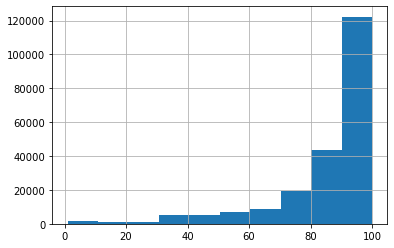

In [18]:
# Checking the range of passage lengths to ensure we have limited number of very small passages
import numpy as np
pass_text = passages_dict.keys()
pass_length = [len(p.split()) for p in pass_text]
df_pass_length = pd.Series(pass_length)
print("Percentage of passages with more than 30 words: ",df_pass_length[df_pass_length > 30].count()/df_pass_length.count())
df_pass_length.hist()

### Splitting dataset for training/testing along different dimensions

In [19]:
from sklearn.model_selection import train_test_split

# Split along query_ids
train_query_ids, test_query_ids = train_test_split(df_joined_short['query_id'], random_state=23, test_size = 0.2)
df_joined_train_query_ids = df_joined_short[df_joined_short['query_id'].isin(train_query_ids)]
df_joined_test_query_ids = df_joined_short[df_joined_short['query_id'].isin(test_query_ids)]
print('Split by Query Id')
print('Length train dataset: ', len(df_joined_train_query_ids))
print('Length test dataset: ', len(df_joined_test_query_ids))
print('\n')

# Split along supplier_ids
train_supplier_ids, test_supplier_ids = train_test_split(df_joined_short['idSupplier'].unique(), random_state=23, test_size = 0.2)
df_joined_train_supplier_ids = df_joined_short[df_joined_short['idSupplier'].isin(train_supplier_ids)]
df_joined_test_supplier_ids = df_joined_short[df_joined_short['idSupplier'].isin(test_supplier_ids)]
train_supplierIds_queryIds = df_joined_short[df_joined_short['idSupplier'].isin(train_supplier_ids)]['query_id']
test_supplierIds_queryIds = df_joined_short[df_joined_short['idSupplier'].isin(test_supplier_ids)]['query_id']
print('Split by Supplier Id')
print('Length train dataset: ', len(df_joined_train_supplier_ids))
print('Length test dataset: ', len(df_joined_test_supplier_ids))
print('\n')

# Checking overlap between lists of query_ids
print('Overlap between lists of query ids:')
print('Train overlap: ', len([i for i in train_supplierIds_queryIds if i in train_query_ids]))
print('Test overlap: ', len([i for i in test_supplierIds_queryIds if i in test_query_ids]))

Split by Query Id
Length train dataset:  6680
Length test dataset:  1670


Split by Supplier Id
Length train dataset:  6534
Length test dataset:  1816


Overlap between lists of query ids:
Train overlap:  5209
Test overlap:  345


In [20]:
df_joined_short.to_csv('df_joined_short.csv', index=False)

# BM25 baseline

In [167]:
df_bm25_full = df_joined_short.copy()
df_bm25_test_query_ids = df_joined_test_query_ids.copy()
df_bm25_test_supplier_ids = df_joined_test_supplier_ids.copy()

### BM25 top passages ranking on whole dataset

In [170]:
from gensim import corpora
from gensim.summarization import bm25
import logging
logging.getLogger("gensim").setLevel(logging.ERROR)

def bm25_rank(query, bm25_passages, num_passages):
    only_passages = [p[2] for p in bm25_passages]
    texts = [str(doc).split() for doc in only_passages]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    bm25_obj = bm25.BM25(corpus)
    query_doc = dictionary.doc2bow(query.split())
    scores = bm25_obj.get_scores(query_doc)
    best_docs_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:min(len(scores),num_passages)]
    return [only_passages[i] for i in best_docs_idx]

In [171]:
import time
start_time = time.time()
df_bm25_full['bm25TopPassages'] = df_bm25_full.apply(lambda x: bm25_rank(x['query'], x['passages'], 100), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))
df_bm25_full

Execution time: 546.0948536396027 seconds


,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,0,0,0,[22],detailed information available on fuel consump...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall...",[fcev: expanded and improved fuel cell stack a...
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,0,0,0,[50],company specific employee awareness programs g...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha...",[ensure that all global employees are aware of...
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,0,0,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",[region • contribute to air quality improvemen...
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,0,0,0,[20],design of the product with special considerati...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch...",[editorial policy contents overview highlights...
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,0,0,0,[12],environmental impact analysis of the product d...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch...",[goals: international goals for the period fro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,32066,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,0,0,0,[4],detailed coverage of company's specific health...,option_help,8345,24,"[[0, 2445552, 1 employee handbook 2019], [1, 2...",[group health insurance coverage if they lose ...
8346,32067,18509,2348,Additional leave beyond standard vacation days,Examples of documents to attach: employee hand...,What actions are in place regarding working co...,1,LAB3201_3,1737,LAB3201,...,0,0,0,"[2, 3]",provision of additional leave beyond standard ...,option_help,8346,22,"[[0, 2445724, handbook employee], [1, 2445725,...",[to the end of the current pay period. the pay...
8347,32069,18510,2348,Flexible organization of work available to emp...,Examples of documents to attach: standard oper...,What actions are in place regarding working co...,1,LAB3201_4,1737,LAB3201,...,0,0,0,[0],provision of flexible working arrangement (eg ...,option_help,8347,33,"[[0, 2445739, page 1 ypsomed holding ag brunnm...",[page 2 about the ypsomed group the ypsomed gr...
8348,32070,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,0,0,0,[1],detailed coverage of company's specific health...,option_help,8348,24,"[[0, 2445746, handbook employee], [1, 2445747,...",[platform is designed to attract and retain mo...


In [172]:
df_bm25_full.to_csv('df_bm25_full.csv', index=False)

### BM25 top passages ranking on query_id test set

In [173]:
import time
start_time = time.time()
df_bm25_test_query_ids['bm25TopPassages'] = df_bm25_test_query_ids.apply(lambda x: bm25_rank(x['query'], x['passages'], 100), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))
df_bm25_test_query_ids

Execution time: 111.5810444355011 seconds


,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,0,0,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",[region • contribute to air quality improvemen...
11,31,16986,2157,Company specific take back programs (e.g. free...,Examples of documents to attach: work instruct...,What actions are in place to reduce environmen...,1,ENV388_10,295,ENV388,...,0,0,0,[32],take-back program at the end of the products' ...,option_help,11,18,"[[0, 4466, —toward the toyota environmental ch...",[the water is life 2018 (global high school st...
15,38,17130,2170,Monitoring direct CO2 emissions,Examples of documents to attach: third-party t...,What actions are in place regarding the reduct...,1,ENV312_70,20,ENV312,...,0,0,0,[22],company monitoring mechanism to keep track of ...,option_help,15,24,"[[0, 6090, —toward the toyota environmental ch...",[governments as well as local communities and ...
17,40,17132,2170,Measures to reduce CO2 emissions from transport,Examples of documents to attach: standard oper...,What actions are in place regarding the reduct...,1,ENV312_90,20,ENV312,...,0,0,0,[24],operational processes or deployment of technol...,option_help,17,28,"[[0, 6902, —toward the toyota environmental ch...","[nature (iucn) at an un conference, and donati..."
28,198,16368,2076,Energy Consumption & GHGs,Examples of documents to attach: annual energy...,On which of the following topics does your com...,1,ENV600_1,1993,ENV600,...,0,0,0,[41],public or internal reporting of consolidated d...,option_help,28,17,"[[0, 9870, sustainability report 2018], [1, 98...",[2 e emission reduction were realized. as a re...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8314,31993,18202,2300,Incident response procedure (IRP) to manage br...,Examples of documents to attach: standard oper...,What actions are in place regarding informatio...,1,FB3301_5,1600,FB3301,...,0,0,0,"[0, 1, 2, 3]","employee instructions or procedure to detect, ...",option_help,8314,24,"[[0, 2443618, issuing organisation: document n...","[the measures taken, or proposed to be taken, ..."
8325,32015,18204,2300,Measures to protect third party data from unau...,Examples of documents to attach: work instruct...,What actions are in place regarding informatio...,1,FB3301_10,1600,FB3301,...,0,0,0,[3],internal controls to restrict physical or digi...,option_help,8325,18,"[[0, 2444079, privacy notice last updated: jan...",[information from children under thirteen 13 y...
8327,32017,19684,2533,Measures to protect third party data from unau...,Examples of documents to attach: work instruct...,What actions are in place regarding informatio...,1,FB3301_10,1600,FB3301,...,0,0,0,[3],internal controls to restrict physical or digi...,option_help,8327,18,"[[0, 2444197, privacy notice last updated: jan...",[information from children under thirteen 13 y...
8329,32019,18204,2300,Measures to protect third party data from unau...,Examples of documents to attach: work instruct...,What actions are in place regarding informatio...,1,FB3301_10,1600,FB3301,...,0,0,0,"[0, 1, 2, 3, 4, 5, 6, 7]",internal controls to restrict physical or digi...,option_help,8329,18,"[[0, 2444315, website privacy statement avaya ...",[that your privacy rights continue to be prote...


In [174]:
df_bm25_test_query_ids.to_csv('df_bm25_test_query_ids.csv', index=False)

### BM25 top passages ranking on supplier_id test set

In [176]:
import time
start_time = time.time()
df_bm25_test_supplier_ids['bm25TopPassages'] = df_bm25_test_supplier_ids.apply(lambda x: bm25_rank(x['query'], x['passages'], 100), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))
df_bm25_test_supplier_ids

Execution time: 111.9452006816864 seconds


,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages
75,424,4760,649,Company products and services to facilitate re...,Examples of documents to attach: product/servi...,What actions are in place regarding promotion ...,1,CP331_30,8,CP331,...,0,0,0,[18],detailed information on take back or recycling...,option_help,75,26,"[[0, 20506, corporate social responsibility v....",[rainwater collector i two separate projects s...
76,425,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,0,0,0,[14],company specific employee awareness programs g...,option_help,76,16,"[[0, 20569, corporate social responsibility v....",[support local social organisations gardening/...
77,427,9670,1202,Others (please specify),Please select this option only if the rest of ...,What actions are in place regarding water mana...,1,ENV321_40_999,28,ENV321,...,0,0,0,[13],what actions are in place regarding water mana...,concat_quest_opt,77,11,"[[0, 20632, corporate social responsibility v....",[our six adopted csr action areas save energy ...
78,434,17073,2166,Reduction of energy consumption through techno...,Examples of documents to attach: standard oper...,What actions are in place regarding the reduct...,1,ENV310_30,240,ENV310,...,0,0,0,[10],deployment of certain technology or equipment ...,option_help,78,14,"[[0, 20695, corporate social responsibility v....",[investments in presses & controls quick set-u...
79,437,17507,2208,Active recycling program for paper/carton,Examples of documents to attach: standard oper...,What actions are in place regarding hazardous ...,1,ENV356_10,40,ENV356,...,0,0,0,[17],employee instructions or operational process t...,option_help,79,13,"[[0, 20758, corporate social responsibility v....",[support local social organisations customers ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,31999,18204,2300,Measures to protect third party data from unau...,Examples of documents to attach: work instruct...,What actions are in place regarding informatio...,1,FB3301_10,1600,FB3301,...,0,0,0,[1],internal controls to restrict physical or digi...,option_help,8318,18,"[[0, 2443810, home data protection/ data prote...",[important information about the safeguarding ...
8337,32052,18486,2346,Regular assessment (at least once a year) of i...,Examples of documents to attach: standard oper...,What actions are in place regarding training a...,1,LAB340_20,105,LAB340,...,0,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",employee instructions or operational process t...,option_help,8337,19,"[[0, 2444471, 2019 yer process . dl briefing. ...",[2019 yer process . dl briefing. for business ...
8346,32067,18509,2348,Additional leave beyond standard vacation days,Examples of documents to attach: employee hand...,What actions are in place regarding working co...,1,LAB3201_3,1737,LAB3201,...,0,0,0,"[2, 3]",provision of additional leave beyond standard ...,option_help,8346,22,"[[0, 2445724, handbook employee], [1, 2445725,...",[to the end of the current pay period. the pay...
8347,32069,18510,2348,Flexible organization of work available to emp...,Examples of documents to attach: standard oper...,What actions are in place regarding working co...,1,LAB3201_4,1737,LAB3201,...,0,0,0,[0],provision of flexible working arrangement (eg ...,option_help,8347,33,"[[0, 2445739, page 1 ypsomed holding ag brunnm...",[page 2 about the ypsomed group the ypsomed gr...


In [177]:
df_bm25_test_supplier_ids.to_csv('df_bm25_test_supplier_ids.csv', index=False)

### Analyzing results

In [41]:
# Reimporting the whole dataset with results of BM25 predictions
import ast
import pandas as pd
df_bm25_full = pd.read_csv('df_bm25_full.csv')
df_bm25_full['bm25TopPassages'] = df_bm25_full['bm25TopPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_full['passages'] = df_bm25_full['passages'].apply(lambda x: ast.literal_eval(x))
df_bm25_full['answerPage'] = df_bm25_full['answerPage'].apply(lambda x: ast.literal_eval(x))
passages_dict = {i[2]:i[0] for p in df_bm25_full['passages'] for i in p}
df_bm25_full.head()

,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages,bm25posPassages,bm25negPassages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,0,[22],detailed information available on fuel consump...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall...",[fcev: expanded and improved fuel cell stack a...,[],['fcev: expanded and improved fuel cell stack ...
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,0,[50],company specific employee awareness programs g...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha...",[ensure that all global employees are aware of...,['with its suppliers. we continued these effor...,['ensure that all global employees are aware o...
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",[region • contribute to air quality improvemen...,['editorial policy contents overview highlight...,['region • contribute to air quality improveme...
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,0,[20],design of the product with special considerati...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch...",[editorial policy contents overview highlights...,['to curb global warming by reducing co2 emiss...,['editorial policy contents overview highlight...
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,0,[12],environmental impact analysis of the product d...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch...",[goals: international goals for the period fro...,['editorial policy contents overview highlight...,['goals: international goals for the period fr...


In [3]:
# Reimporting the query_id test dataset with results of BM25 predictions
import ast
import pandas as pd
df_bm25_test_query_ids = pd.read_csv('df_bm25_test_query_ids.csv')
df_bm25_test_query_ids['bm25TopPassages'] = df_bm25_test_query_ids['bm25TopPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_test_query_ids['passages'] = df_bm25_test_query_ids['passages'].apply(lambda x: ast.literal_eval(x))
df_bm25_test_query_ids['answerPage'] = df_bm25_test_query_ids['answerPage'].apply(lambda x: ast.literal_eval(x))
passages_dict = {i[2]:i[0] for p in df_bm25_test_query_ids['passages'] for i in p}
df_bm25_test_query_ids.head()

,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,percentQuest,cdpQuest,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages
0,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,0,0,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",[region • contribute to air quality improvemen...
1,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,0,0,0,[12],environmental impact analysis of the product d...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch...",[goals: international goals for the period fro...
2,31,16986,2157,Company specific take back programs (e.g. free...,Examples of documents to attach: work instruct...,What actions are in place to reduce environmen...,1,ENV388_10,295,ENV388,...,0,0,0,[32],take-back program at the end of the products' ...,option_help,11,18,"[[0, 4466, —toward the toyota environmental ch...",[the water is life 2018 (global high school st...
3,38,17130,2170,Monitoring direct CO2 emissions,Examples of documents to attach: third-party t...,What actions are in place regarding the reduct...,1,ENV312_70,20,ENV312,...,0,0,0,[22],company monitoring mechanism to keep track of ...,option_help,15,24,"[[0, 6090, —toward the toyota environmental ch...",[governments as well as local communities and ...
4,40,17132,2170,Measures to reduce CO2 emissions from transport,Examples of documents to attach: standard oper...,What actions are in place regarding the reduct...,1,ENV312_90,20,ENV312,...,0,0,0,[24],operational processes or deployment of technol...,option_help,17,28,"[[0, 6902, —toward the toyota environmental ch...","[nature (iucn) at an un conference, and donati..."


In [ ]:
# Reimporting the supplier_id test dataset with results of BM25 predictions
import ast
import pandas as pd
df_bm25_test_supplier_ids = pd.read_csv('df_bm25_test_supplier_ids.csv')
df_bm25_test_supplier_ids['bm25TopPassages'] = df_bm25_test_supplier_ids['bm25TopPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_test_supplier_ids['passages'] = df_bm25_test_supplier_ids['passages'].apply(lambda x: ast.literal_eval(x))
df_bm25_test_supplier_ids['answerPage'] = df_bm25_test_supplier_ids['answerPage'].apply(lambda x: ast.literal_eval(x))
passages_dict = {i[2]:i[0] for p in df_bm25_test_supplier_ids['passages'] for i in p}
df_bm25_test_supplier_ids.head()

In [55]:
# Scoring success on top k results
def predict_pages_BM25(k, BM25_top_passage, answer_page):
    prediction = 0
    for j in range(k):
        try:
            if passages_dict[BM25_top_passage[j]] in answer_page:
                prediction = 1 
        except:
            pass
    return prediction

In [456]:
# Running the evaluation on whole dataset
print('Results on whole dataset:')
for k in [1,3,5,10]:
    results = df_bm25_full.apply(lambda x: predict_pages_BM25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on whole dataset:
Success @ 1: 0.206587
Success @ 3: 0.365389
Success @ 5: 0.448383
Success @ 10: 0.566228


In [180]:
# Investigating the distribution of Success@3 depending on the type of report
import itertools

grouped_type = df_bm25_full.groupby('typeName')['query_id', 'answerPage', 'numPages', 'bm25TopPassages']
df_bm25_full_type = grouped_type.aggregate(lambda x: list(x))
df_bm25_full_type = df_bm25_full_type.reset_index()
df_bm25_full_type['numPages'] = df_bm25_full_type['numPages'].apply(lambda x: np.mean(x))
#df_bm25_full_type['query_id'] = df_bm25_full_type['query_id'].apply(lambda x: int(str(list(set(x))).strip('[]')))
df_bm25_full_type['answerPage'] = df_bm25_full_type['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_bm25_full_type

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,typeName,query_id,answerPage,numPages,bm25TopPassages
0,Annual_Report,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...","[[34, 27], [27], [90], [53], [41, 95], [41, 4]...",97.171956,[[deadlines contain action plans to reach the ...
1,Audit_Report,"[5207, 5208, 5209, 5210, 5211, 5212, 5213, 521...","[[24], [20], [23], [20], [28], [32], [26], [44...",28.487805,[[safe and healthy workplace. failure to compl...
2,CSR_Report,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[[38], [34], [27], [21], [41], [42], [41, 42],...",71.816555,"[[in 2018, 126 suppliers were evaluated in ter..."
3,Certificate,"[2377, 3875, 4176, 4190, 4216, 4217, 4244, 530...","[[0], [0, 1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3...",8.625000,[[fairtrade certificate sucafina s.a. flo id 5...
4,Code_of_Ethics_Code_of_Conduct,"[898, 899, 900, 2350, 2351, 2352, 2553, 2554, ...","[[], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...",19.844498,[[code of conduct for huhtamaki suppliers | da...
5,Employee_Handbook,"[431, 432, 433, 434, 435, 436, 437, 438, 453, ...","[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, ...",56.364130,[[with the performance of your job or create a...
6,Letter_to_EcoVadis,"[5236, 5237, 5238, 5239, 5240, 5241, 5242]","[[66], [21], [44], [25], [29, 30], [12], [39]]",82.000000,[[comment gefco awards program (stim) allows a...
7,Other,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[22], [50], [31], [20], [12], [51], [26, 54],...",43.613583,[[fcev: expanded and improved fuel cell stack ...
8,Policy,"[439, 440, 441, 442, 443, 444, 445, 446, 447, ...","[[42], [14], [21], [20], [23], [32], [15], [18...",29.066964,[[make sure no outside persons can hear your c...
9,Procedure,"[169, 171, 630, 631, 1665, 1666, 1667, 1780, 1...","[[], [0, 1, 2], [10], [12], [0, 1, 2, 3], [0, ...",16.050388,[[head of department (hod) shall take all prac...


In [181]:
types = df_bm25_full_type['typeName'].tolist()
print('Success @ 3 for type:')
for s in types:
    index_s = types.index(s)
    query_idx = df_bm25_full_type.query_id.iloc[types.index(s)]
    df_types_temp = df_bm25_full[df_bm25_full['query_id'].isin(query_idx)]
    results = df_types_temp.apply(lambda x: predict_pages_BM25(3, x['bm25TopPassages'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {} with average {:.0f} pages: {:f}".format(s, df_bm25_full_type['numPages'].iloc[index_s], sum(results)/len(results)))

Success @ 3 for type:
  Annual_Report with average 97 pages: 0.296068
  Audit_Report with average 28 pages: 0.414634
  CSR_Report with average 72 pages: 0.282899
  Certificate with average 9 pages: 0.625000
  Code_of_Ethics_Code_of_Conduct with average 20 pages: 0.555024
  Employee_Handbook with average 56 pages: 0.395652
  Letter_to_EcoVadis with average 82 pages: 0.000000
  Other with average 44 pages: 0.466042
  Policy with average 29 pages: 0.584821
  Procedure with average 16 pages: 0.596899
  Supplier_Code_of_Conduct with average 11 pages: 0.600000
  Webpage_Intranet_extract with average 6 pages: 0.716535


In [66]:
# Investigating the distribution of Success@3 depending on the size of the documents

def page_range(x):
    if x < 31:
        pageRange = '2-30'
    elif x < 61:
        pageRange = '31-60'
    else:
        pageRange = '61-more'
    return pageRange

df_bm25_full['pageRange'] = df_bm25_full['numPages'].apply(lambda x: page_range(x))
df_bm25_full['pageRange'].value_counts()

61-more    3613
2-30       2374
31-60      2363
Name: pageRange, dtype: int64

In [67]:
import itertools

grouped_range = df_bm25_full.groupby('pageRange')['query_id', 'answerPage', 'numPages', 'bm25TopPassages']
df_bm25_full_range = grouped_range.aggregate(lambda x: list(x))
df_bm25_full_range = df_bm25_full_range.reset_index()
df_bm25_full_range['numPages'] = df_bm25_full_range['numPages'].apply(lambda x: np.mean(x))
df_bm25_full_range['answerPage'] = df_bm25_full_range['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])

ranges = df_bm25_full_range['pageRange'].tolist()
print('Success @ 3 for range:')
for s in ranges:
    index_s = ranges.index(s)
    query_idx = df_bm25_full_range.query_id.iloc[ranges.index(s)]
    df_ranges_temp = df_bm25_full[df_bm25_full['query_id'].isin(query_idx)]
    results = df_ranges_temp.apply(lambda x: predict_pages_BM25(3, x['bm25TopPassages'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for range:
  2-30: 0.581719
  31-60: 0.320779
  61-more: 0.252422


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [459]:
# Scoring MRR on top k results
def eval_MRR_bm25(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_bm25_full.apply(lambda x: eval_MRR_bm25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.206587
MRR @ 3: 0.274651
MRR @ 5: 0.293513
MRR @ 10: 0.309341


In [457]:
# Running the evaluation on query_id test set
print('Results on query_id test set:')
for k in [1,3,5,10]:
    results = df_bm25_test_query_ids.apply(lambda x: predict_pages_BM25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on query_id test set:
Success @ 1: 0.189222
Success @ 3: 0.350299
Success @ 5: 0.442515
Success @ 10: 0.552695


In [460]:
# Scoring MRR on top k results
def eval_MRR_bm25(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_bm25_test_query_ids.apply(lambda x: eval_MRR_bm25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.189222
MRR @ 3: 0.257186
MRR @ 5: 0.278443
MRR @ 10: 0.293377


In [458]:
# Running the evaluation on supplier_id test set
print('Results on supplier_id test set:')
for k in [1,3,5,10]:
    results = df_bm25_test_supplier_ids.apply(lambda x: predict_pages_BM25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on supplier_id test set:
Success @ 1: 0.207599
Success @ 3: 0.373348
Success @ 5: 0.454846
Success @ 10: 0.584802


In [461]:
# Scoring MRR on top k results
def eval_MRR_bm25(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_bm25_test_supplier_ids.apply(lambda x: eval_MRR_bm25(k, x['bm25TopPassages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.207599
MRR @ 3: 0.278543
MRR @ 5: 0.297155
MRR @ 10: 0.314754


In [184]:
# Manual inspection
import random
df_temp_bm25 = df_bm25_full.copy()
#df_temp_bm25 = df_bm25_test_query_ids.copy()
#df_temp_bm25 = df_bm25_test_supplier_ids.copy()
idx = random.randint(0, len(df_temp_bm25))
print('Index: ', idx)
print('Query type: ', df_temp_bm25['query_type'].iloc[idx])
print('Query: ', df_temp_bm25['query'].iloc[idx])
print('\n')
print('Answer pages by Analysts: ', df_temp_bm25['answerPage'].iloc[idx])
print('Total pages number in doc: ', df_temp_bm25['numPages'].iloc[idx])
print("\n")
print("Top passage #1: [{}] {}".format(passages_dict[df_temp_bm25['bm25TopPassages'].iloc[idx][0]], df_temp_bm25['bm25TopPassages'].iloc[idx][0]))
print("\n")
print("Top passage #2: [{}] {}".format(passages_dict[df_temp_bm25['bm25TopPassages'].iloc[idx][1]], df_temp_bm25['bm25TopPassages'].iloc[idx][1]))
print("\n")
print("Top passage #3: [{}] {}".format(passages_dict[df_temp_bm25['bm25TopPassages'].iloc[idx][2]], df_temp_bm25['bm25TopPassages'].iloc[idx][2]))

Index:  7203
Query type:  option_help
Query:  established mechanism for different parties to report any cases of discrimination and/or harassment and inclusion of 1) confidentiality guarantee 2) non-retaliation guarantee and 3) dedicated reporting channel (ie internal or third-party email, phone/hotline, contact person in compliance department.).


Answer pages by Analysts:  [53]
Total pages number in doc:  61.0


Top passage #1: [14] the committee (management, hod & hr) shall be responsible for the proposal of concerned promotion. in case of exceptional performance by a member, above guidelines for promotion can be altered with permission from management. promotion shall mainly depend upon the following criteria: - 1) performance of member 2) availability of positions 3) as per the guidelines and policy structure of increment the increments are categorized in a five point scale as excellent, very good, good, fair & unsatisfactory. the increments are classified in the mentioned group a

In [185]:
### Using BM25 predictions to separate positive and negative passages
def pos_passages(top_passages, col_answerPage):
    pos_passages = [top_passages[i] for i in range(len(top_passages)) if passages_dict[top_passages[i]] in col_answerPage]
    return pos_passages

def neg_passages(top_passages, col_answerPage):
    neg_passages = [top_passages[i] for i in range(len(top_passages)) if passages_dict[top_passages[i]] not in col_answerPage]
    return neg_passages

passages_dict = {i[2]:i[0] for p in df_bm25_full['passages'] for i in p}

df_bm25_full['bm25posPassages'] = df_bm25_full.apply(lambda x: pos_passages(x['bm25TopPassages'], x['answerPage']), axis=1)
df_bm25_full['bm25negPassages'] = df_bm25_full.apply(lambda x: neg_passages(x['bm25TopPassages'], x['answerPage']), axis=1)

df_bm25_test_query_ids['bm25posPassages'] = df_bm25_test_query_ids.apply(lambda x: pos_passages(x['bm25TopPassages'], x['answerPage']), axis=1)
df_bm25_test_query_ids['bm25posPassages'] = df_bm25_test_query_ids.apply(lambda x: neg_passages(x['bm25TopPassages'], x['answerPage']), axis=1)

df_bm25_test_supplier_ids['bm25negPassages'] = df_bm25_test_supplier_ids.apply(lambda x: pos_passages(x['bm25TopPassages'], x['answerPage']), axis=1)
df_bm25_test_supplier_ids['bm25negPassages'] = df_bm25_test_supplier_ids.apply(lambda x: neg_passages(x['bm25TopPassages'], x['answerPage']), axis=1)

In [186]:
df_bm25_full.to_csv('df_bm25_full.csv', index=False)

# PyGaggle T5 baseline

In [6]:
from pygaggle.rerank.base import Query, Text
from pygaggle.rerank.transformer import MonoT5

reranker =  MonoT5()

2021-05-30 13:50:28 [INFO] loader: Loading faiss with AVX2 support.
2021-05-30 13:50:28 [INFO] loader: Loading faiss.
Some weights of the model checkpoint at castorini/monot5-base-msmarco were not used when initializing T5ForConditionalGeneration: ['decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight']
- This IS expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing T5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### PyGaggle Reranker on whole dataset

In [ ]:
# Creating queries and passages in PyGaggle formats
df_joined_short['pygaggleQuery'] = df_joined_short['query'].apply(lambda x: Query(x))
df_joined_short['pygagglePassages'] = df_joined_short['passages'].apply(lambda x: [Text(p[2], {'docid': p[1]}, 0) for p in x])

In [ ]:
# To test the T5 reranker on a sample of the dataset
df_joined_veryshort = df_joined_short[(df_joined_short.wordCount < 500)]
print("Number of questions-answers: ", len(df_joined_veryshort))
print("Number of passages: ", df_joined_veryshort.wordCount.sum()/100)

In [ ]:
#df_T5 = df_joined_veryshort.copy()
df_T5_full = df_joined_short.copy()

In [ ]:
import time
start_time = time.time()
df_T5_full['rerankedPassages'] = df_T5_full.apply(lambda x: reranker.rerank(x['pygaggleQuery'], x['pygagglePassages']), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))

In [ ]:
# Extracting the top 100 passages per query
def top_100_passages(texts):
    top_list = []
    for i in range(0, min(100,len(texts))):
        top_list.append([i+1, texts[i].metadata["docid"], texts[i].score, texts[i].text])
    return top_list

df_T5_full['T5Top100Passages'] = df_T5_full['rerankedPassages'].apply(lambda x: top_100_passages(x))

In [ ]:
df_T5_full.to_csv('df_T5_full.csv', index=False)

### PyGaggle Reranker on query_id test set

In [7]:
# Creating queries and passages in PyGaggle formats
df_joined_test_query_ids['pygaggleQuery'] = df_joined_test_query_ids['query'].apply(lambda x: Query(x))
df_joined_test_query_ids['pygagglePassages'] = df_joined_test_query_ids['passages'].apply(lambda x: [Text(p[2], {'docid': p[1]}, 0) for p in x])
df_T5_test_query_ids = df_joined_test_query_ids.copy()

In [ ]:
import time
start_time = time.time()
df_T5_test_query_ids['rerankedPassages'] = df_T5_test_query_ids.apply(lambda x: reranker.rerank(x['pygaggleQuery'], x['pygagglePassages']), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))

In [ ]:
# Extracting the top 100 passages per query
def top_100_passages(texts):
    top_list = []
    for i in range(0, min(100,len(texts))):
        top_list.append([i+1, texts[i].metadata["docid"], texts[i].score, texts[i].text])
    return top_list

df_T5_test_query_ids['T5Top100Passages'] = df_T5_test_query_ids['rerankedPassages'].apply(lambda x: top_100_passages(x))

In [ ]:
df_T5_test_query_ids.to_csv('df_T5_test_query_ids.csv', index=False)

### PyGaggle Reranker on supplier_id test set

In [ ]:
# Creating queries and passages in PyGaggle formats
df_joined_test_supplier_ids['pygaggleQuery'] = df_joined_test_supplier_ids['query'].apply(lambda x: Query(x))
df_joined_test_supplier_ids['pygagglePassages'] = df_joined_test_supplier_ids['passages'].apply(lambda x: [Text(p[2], {'docid': p[1]}, 0) for p in x])
df_T5_test_supplier_ids = df_joined_test_supplier_ids.copy()

In [ ]:
import time
start_time = time.time()
df_T5_test_supplier_ids['rerankedPassages'] = df_T5_test_supplier_ids.apply(lambda x: reranker.rerank(x['pygaggleQuery'], x['pygagglePassages']), axis=1)
print('Execution time: {} seconds'.format(time.time() - start_time))

In [ ]:
# Extracting the top 100 passages per query
def top_100_passages(texts):
    top_list = []
    for i in range(0, min(100,len(texts))):
        top_list.append([i+1, texts[i].metadata["docid"], texts[i].score, texts[i].text])
    return top_list

df_T5_test_supplier_ids['T5Top100Passages'] = df_T5_test_supplier_ids['rerankedPassages'].apply(lambda x: top_100_passages(x))

In [ ]:
df_T5_test_supplier_ids.to_csv('df_T5_test_supplier_ids.csv', index=False)

### Analyze results

In [58]:
# Reimporting the whole dataset with results of T5 predictions
import ast
df_T5_full = pd.read_csv('df_T5_top100.csv')
df_T5_full['T5Top100Passages'] = df_T5_full['T5Top100Passages'].apply(lambda x: ast.literal_eval(x))
df_T5_full['passages'] = df_T5_full['passages'].apply(lambda x: ast.literal_eval(x))
df_T5_full['answerPage'] = df_T5_full['answerPage'].apply(lambda x: ast.literal_eval(x))
passages_dict = {i[2]:i[0] for p in df_T5_full['passages'] for i in p}
df_T5_full.head()

,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,query_type,query_id,queryWordCount,passages,pygaggleQuery,pygagglePassages,rerankedPassages,T5Top100Passages,T5posPassages,T5negPassages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 162, -0.09654336422681808, data of the re...","[[2, 152, -2.076173782348633, 'stage. in this ...","[[1, 162, -0.09654336422681808, 'data of the r..."
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 768, -0.02047719992697239, ensure that al...","[[37, 755, -9.55618953704834, 'to protect huma...","[[1, 768, -0.02047719992697239, 'ensure that a..."
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 862, -0.6157100796699524, at newly establ...","[[7, 1027, -8.945672988891602, 'makes it imper...","[[1, 862, -0.6157100796699524, 'at newly estab..."
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 1370, -0.20025764405727386, stage. in thi...","[[11, 1359, -5.017537593841553, 'to curb globa...","[[1, 1370, -0.20025764405727386, 'stage. in th..."
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 1776, -0.015775874257087708, stage. in th...","[[4, 1692, -0.03989306464791298, 'will contrib...","[[1, 1776, -0.015775874257087708, 'stage. in t..."


In [219]:
# Rebuilding query_id and supplier_id test sets with T5 predictions
df_T5_test_query_ids = df_T5_full[df_T5_full['query_id'].isin(test_query_ids)]

df_T5_test_supplier_ids = df_T5_full[df_T5_full['query_id'].isin(test_supplierIds_queryIds)]

In [59]:
# Scoring success on top k results
def predict_pages_T5(k, T5_top_passage, answer_page):
    prediction = 0
    for j in range(k):
        try:
            if passages_dict[T5_top_passage[j][3]] in answer_page:
                prediction = 1 
        except:
            pass
    return prediction

In [449]:
# Running the evaluation on whole dataset
print('Results on whole dataset:')

for k in [1,3,5,10]:
    results = df_T5_full.apply(lambda x: predict_pages_T5(k, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on whole dataset:
Success @ 1: 0.407305
Success @ 3: 0.591377
Success @ 5: 0.659042
Success @ 10: 0.745269


In [222]:
# Investigating the distribution of Success@3 depending on the type of report
import itertools

grouped_type_T5 = df_T5_full.groupby('typeName')['query_id', 'answerPage', 'numPages', 'T5Top100Passages']
df_T5_full_type = grouped_type_T5.aggregate(lambda x: list(x))
df_T5_full_type = df_T5_full_type.reset_index()
df_T5_full_type['numPages'] = df_T5_full_type['numPages'].apply(lambda x: np.mean(x))
#df_bm25_full_type['query_id'] = df_bm25_full_type['query_id'].apply(lambda x: int(str(list(set(x))).strip('[]')))
df_T5_full_type['answerPage'] = df_T5_full_type['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_T5_full_type

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,typeName,query_id,answerPage,numPages,T5Top100Passages
0,Annual_Report,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...","[[34, 27], [27], [90], [53], [41, 95], [41, 4]...",97.171956,"[[[1, 20902, -0.042886167764663696, 31 the amb..."
1,Audit_Report,"[5207, 5208, 5209, 5210, 5211, 5212, 5213, 521...","[[24], [20], [23], [20], [28], [32], [26], [44...",28.487805,"[[[1, 1807338, -0.11901791393756866, personal ..."
2,CSR_Report,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[[38], [34], [27], [21], [41], [42], [41, 42],...",71.816555,"[[[1, 8576, -2.580763101577759, s u st a in a ..."
3,Certificate,"[2377, 3875, 4176, 4190, 4216, 4217, 4244, 530...","[[0], [0, 1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3...",8.625000,"[[[1, 821124, -0.4873693585395813, fairtrade c..."
4,Code_of_Ethics_Code_of_Conduct,"[898, 899, 900, 2350, 2351, 2352, 2553, 2554, ...","[[], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...",19.844498,"[[[1, 226072, -0.061277732253074646, legal per..."
5,Employee_Handbook,"[431, 432, 433, 434, 435, 436, 437, 438, 453, ...","[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, ...",56.364130,"[[[1, 131281, -5.9307966232299805, includes: (..."
6,Letter_to_EcoVadis,"[5236, 5237, 5238, 5239, 5240, 5241, 5242]","[[66], [21], [44], [25], [29, 30], [12], [39]]",82.000000,"[[[1, 1811050, -1.772041916847229, co2 program..."
7,Other,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[22], [50], [31], [20], [12], [51], [26, 54],...",43.613583,"[[[1, 162, -0.09654336422681808, data of the r..."
8,Policy,"[439, 440, 441, 442, 443, 444, 445, 446, 447, ...","[[42], [14], [21], [20], [23], [32], [15], [18...",29.066964,"[[[1, 132955, -0.09250561147928238, care of ti..."
9,Procedure,"[169, 171, 630, 631, 1665, 1666, 1667, 1780, 1...","[[], [0, 1, 2], [10], [12], [0, 1, 2, 3], [0, ...",16.050388,"[[[1, 36058, -0.012019116431474686, head of de..."


In [223]:
T5_types = df_T5_full_type['typeName'].tolist()
print('Success @ 3 for type:')
for s in T5_types:
    index_s_T5 = T5_types.index(s)
    query_idx_T5 = df_T5_full_type.query_id.iloc[T5_types.index(s)]
    df_types_temp_T5 = df_T5_full[df_T5_full['query_id'].isin(query_idx_T5)]
    results = df_types_temp_T5.apply(lambda x: predict_pages_T5(3, x['T5Top100Passages'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {} with average {:.0f} pages: {:f}".format(s, df_T5_full_type['numPages'].iloc[index_s_T5], sum(results)/len(results)))

Success @ 3 for type:
  Annual_Report with average 97 pages: 0.559450
  Audit_Report with average 28 pages: 0.658537
  CSR_Report with average 72 pages: 0.532141
  Certificate with average 9 pages: 0.562500
  Code_of_Ethics_Code_of_Conduct with average 20 pages: 0.734450
  Employee_Handbook with average 56 pages: 0.688043
  Letter_to_EcoVadis with average 82 pages: 0.142857
  Other with average 44 pages: 0.576112
  Policy with average 29 pages: 0.696429
  Procedure with average 16 pages: 0.682171
  Supplier_Code_of_Conduct with average 11 pages: 0.636364
  Webpage_Intranet_extract with average 6 pages: 0.787402


In [453]:
# Scoring MRR on top k results
def eval_MRR_T5(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j][3]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_T5_full.apply(lambda x: eval_MRR_T5(k, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.407305
MRR @ 3: 0.488104
MRR @ 5: 0.503523
MRR @ 10: 0.515100


In [224]:
# Running the evaluation on query_id test set
print('Results on query_id test set:')

for k in [1,3,5,10]:
    results = df_T5_test_query_ids.apply(lambda x: predict_pages_T5(k, df_T5_test_query_ids, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on query_id test set:
Success @ 1: 0.393413
Success @ 3: 0.580240
Success @ 5: 0.654491
Success @ 10: 0.752695


In [64]:
# Investigating the distribution of Success@3 depending on the size of the documents

def page_range(x):
    if x < 31:
        pageRange = '2-30'
    elif x < 61:
        pageRange = '31-60'
    else:
        pageRange = '61-more'
    return pageRange

df_T5_full['pageRange'] = df_T5_full['numPages'].apply(lambda x: page_range(x))

import itertools

grouped_range_T5 = df_T5_full.groupby('pageRange')['query_id', 'answerPage', 'numPages', 'T5Top100Passages']
df_T5_full_range = grouped_range_T5.aggregate(lambda x: list(x))
df_T5_full_range = df_T5_full_range.reset_index()
df_T5_full_range['numPages'] = df_T5_full_range['numPages'].apply(lambda x: np.mean(x))
df_T5_full_range['answerPage'] = df_T5_full_range['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])

T5_ranges = df_T5_full_range['pageRange'].tolist()
print('Success @ 3 for range:')
for s in T5_ranges:
    index_s_T5 = T5_ranges.index(s)
    query_idx_T5 = df_T5_full_range.query_id.iloc[T5_ranges.index(s)]
    df_ranges_temp_T5 = df_T5_full[df_T5_full['query_id'].isin(query_idx_T5)]
    results = df_ranges_temp_T5.apply(lambda x: predict_pages_T5(3, x['T5Top100Passages'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for range:
  2-30: 0.716091
  31-60: 0.578925
  61-more: 0.517575


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


In [454]:
# Scoring MRR on top k results
def eval_MRR_T5(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j][3]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_T5_test_query_ids.apply(lambda x: eval_MRR_T5(k, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.393413
MRR @ 3: 0.475349
MRR @ 5: 0.492086
MRR @ 10: 0.504962


In [225]:
# Running the evaluation on supplier_id test set
print('Results on supplier_id test set:')

for k in [1,3,5,10]:
    results = df_T5_test_supplier_ids.apply(lambda x: predict_pages_T5(k, df_T5_test_supplier_ids, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Results on supplier_id test set:
Success @ 1: 0.416850
Success @ 3: 0.615088
Success @ 5: 0.681718
Success @ 10: 0.775881


In [462]:
# Scoring MRR on top k results
def eval_MRR_T5(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if passages_dict[top_passages[j][3]] in answer_page and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_T5_test_supplier_ids.apply(lambda x: eval_MRR_T5(k, x['T5Top100Passages'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.416850
MRR @ 3: 0.503120
MRR @ 5: 0.518264
MRR @ 10: 0.530735


In [226]:
# Manual inspection
import random
df_temp = df_T5_full.copy()
#df_temp = df_T5_test_query_ids.copy()
#df_temp = df_T5_test_supplier_ids.copy()
idx = random.randint(0, len(df_temp)-1)
print('Index: ', idx)
print('Query type: ', df_temp['query_type'].iloc[idx])
print('Query: ', df_temp['query'].iloc[idx])
print('\n')
print('Answer pages by Analysts: ', df_temp['answerPage'].iloc[idx])
print('Total pages number in doc: ', df_temp['numPages'].iloc[idx])
print("\n")
print("Top passage #1: [{}] {}".format(passages_dict[df_temp['T5Top100Passages'].iloc[idx][0][3]], df_temp['T5Top100Passages'].iloc[idx][0]))
print("\n")
print("Top passage #2: [{}] {}".format(passages_dict[df_temp['T5Top100Passages'].iloc[idx][1][3]], df_temp['T5Top100Passages'].iloc[idx][1]))
print("\n")
print("Top passage #3: [{}] {}".format(passages_dict[df_temp['T5Top100Passages'].iloc[idx][2][3]], df_temp['T5Top100Passages'].iloc[idx][2]))
print("\n")
#print("Source Text: ", df_T5.textStr.iloc[idx])

Index:  6818
Query type:  option_help
Query:  training programs in web-based or in-person format provided to employees to strengthen their knowledge on external stakeholders human rights related to the company's operation. examples of external stakeholders human rights are land rights, indigenous rights, right to clean water, etc.


Answer pages by Analysts:  [34]
Total pages number in doc:  72.0


Top passage #1: [35] [1, 2207725, -0.012813732959330082, 'of our employees received training on aspects of our human rights policy in sessions totaling around 238,000 hours. aspects of human rights are also covered in the training offerings and the sustainability manual for our suppliers. if there are indica- tions of violations of our human rights policy, employees and members of the general public can contact the world- wide compliance hotline, which is available in numerous national languages. this can also be done anonymously if desired. we verify the observation of human rights at our s

In [227]:
### Using T5 predictions to separate positive and negative passages
def pos_passages(top_passages, col_answerPage):
    pos_passages = [top_passages[i] for i in range(len(top_passages)) if passages_dict[top_passages[i][3]] in col_answerPage]
    return pos_passages

def neg_passages(top_passages, col_answerPage):
    neg_passages = [top_passages[i] for i in range(len(top_passages)) if passages_dict[top_passages[i][3]] not in col_answerPage]
    return neg_passages

df_T5_full['T5posPassages'] = df_T5_full.apply(lambda x: pos_passages(x['T5Top100Passages'], x['answerPage']), axis=1)
df_T5_full['T5negPassages'] = df_T5_full.apply(lambda x: neg_passages(x['T5Top100Passages'], x['answerPage']), axis=1)

df_T5_test_query_ids['T5posPassages'] = df_T5_test_query_ids.apply(lambda x: pos_passages(x['T5Top100Passages'], x['answerPage']), axis=1)
df_T5_test_query_ids['T5negPassages'] = df_T5_test_query_ids.apply(lambda x: neg_passages(x['T5Top100Passages'], x['answerPage']), axis=1)

df_T5_test_supplier_ids['T5posPassages'] = df_T5_test_supplier_ids.apply(lambda x: pos_passages(x['T5Top100Passages'], x['answerPage']), axis=1)
df_T5_test_supplier_ids['T5negPassages'] = df_T5_test_supplier_ids.apply(lambda x: neg_passages(x['T5Top100Passages'], x['answerPage']), axis=1)

In [ ]:
df_T5_full.to_csv('df_T5_full.csv', index=False)
df_T5_test_query_ids.to_csv('df_T5_test_query_ids.csv', index=False)
df_T5_test_supplier_ids.to_csv('df_T5_test_supplier_ids.csv', index=False)

# ELECTRA training

### Choosing starting point: BM25 or T5 top-k passages

In [7]:
# Reimporting the whole dataset with results of T5 predictions to choose positive and negative examples
import ast
df_T5_100 = pd.read_csv('df_T5_top100.csv')
df_T5_100['T5Top100Passages'] = df_T5_100['T5Top100Passages'].apply(lambda x: ast.literal_eval(x))
df_T5_100['T5posPassages'] = df_T5_100['T5posPassages'].apply(lambda x: ast.literal_eval(x))
df_T5_100['T5negPassages'] = df_T5_100['T5negPassages'].apply(lambda x: ast.literal_eval(x))
df_T5_100['bm25TopPassages'] = df_T5_100['bm25TopPassages'].apply(lambda x: ast.literal_eval(x))
df_T5_100['passages'] = df_T5_100['passages'].apply(lambda x: ast.literal_eval(x))
#df_T5_100['answerPage'] = df_T5_100['answerPage'].apply(lambda x: ast.literal_eval(x))

In [9]:
# Reimporting the whole dataset with results of BM25 predictions to choose positive and negative examples
import ast
df_bm25_full = pd.read_csv('df_bm25_full.csv')
df_bm25_full['bm25TopPassages'] = df_bm25_full['bm25TopPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_full['bm25posPassages'] = df_bm25_full['bm25posPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_full['bm25negPassages'] = df_bm25_full['bm25negPassages'].apply(lambda x: ast.literal_eval(x))
df_bm25_full['passages'] = df_bm25_full['passages'].apply(lambda x: ast.literal_eval(x))
#df_bm25_full['answerPage'] = df_bm25_full['answerPage'].apply(lambda x: ast.literal_eval(x))

In [10]:
# Re-computing anwserPages since ast causing error during reimport
def removeFakePgNbrs(pageNbr):
    pageNbr = pageNbr.lower().replace("l0", "").replace("l-1", "").replace("l1", "")
    return pageNbr
    

def removeYears(pageNbr):
    l = re.findall(r'\d{4}', pageNbr)
    if len(l)!=0:
        for s in l:
            pageNbr = pageNbr.replace(s, '')
    return pageNbr


def getPagesWhenRange(pageNbr):
    pgs = re.search(r'\d+\s*-\s*\d+', pageNbr).group().split("-")
    start = int(pgs[0])-1
    end = int(pgs[1])
    range_nbr = list(range(start, end))
    others = re.findall(r'\d+', pageNbr)
    others = [int(i)-1 for i in others]
    all_pgs = range_nbr + others
    return list(set(all_pgs))
    

def cleanPageNbr(pageNbr):
    """
    :param pageNbr: non-standard text introduced by analyst
    :return: list of string : cleaned page numbers
    """
    pageNbr = str(pageNbr)
    pageNbr = removeFakePgNbrs(pageNbr)
    pageNbr = removeYears(pageNbr)
    if re.findall(r'\d+\s*-\s*\d+', pageNbr):
        pages = getPagesWhenRange(pageNbr)
        return pages 
    pages = re.findall(r'\d+', pageNbr)
    pages = [int(i)-1 for i in pages if i!= 0]
    return list(set(pages))

#df_T5_100['answerPage'] = df_T5_100.apply(lambda x: cleanPageNbr(x['analystSource']), axis=1)
df_bm25_full['answerPage'] = df_bm25_full.apply(lambda x: cleanPageNbr(x['analystSource']), axis=1)

In [11]:
#df_electra = df_T5_100.copy()
df_electra = df_bm25_full.copy()
df_electra

,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,certificateQuest,answerPage,query,query_type,query_id,queryWordCount,passages,bm25TopPassages,bm25posPassages,bm25negPassages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,0,[22],detailed information available on fuel consump...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall...",[fcev: expanded and improved fuel cell stack a...,[],[fcev: expanded and improved fuel cell stack a...
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,0,[50],company specific employee awareness programs g...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha...",[ensure that all global employees are aware of...,[with its suppliers. we continued these effort...,[ensure that all global employees are aware of...
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,0,[31],implementation of innovative equipment to enab...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",[region • contribute to air quality improvemen...,[editorial policy contents overview highlights...,[region • contribute to air quality improvemen...
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,0,[20],design of the product with special considerati...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch...",[editorial policy contents overview highlights...,[to curb global warming by reducing co2 emissi...,[editorial policy contents overview highlights...
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,0,[12],environmental impact analysis of the product d...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch...",[goals: international goals for the period fro...,[editorial policy contents overview highlights...,[goals: international goals for the period fro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,32066,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,0,[4],detailed coverage of company's specific health...,option_help,8345,24,"[[0, 2445552, 1 employee handbook 2019], [1, 2...",[group health insurance coverage if they lose ...,[from the employee’s paycheck before taxes are...,[group health insurance coverage if they lose ...
8346,32067,18509,2348,Additional leave beyond standard vacation days,Examples of documents to attach: employee hand...,What actions are in place regarding working co...,1,LAB3201_3,1737,LAB3201,...,0,"[2, 3]",provision of additional leave beyond standard ...,option_help,8346,22,"[[0, 2445724, handbook employee], [1, 2445725,...",[to the end of the current pay period. the pay...,[to the end of the current pay period. the pay...,"[handbook employee, revised 6.28.19 2 family m..."
8347,32069,18510,2348,Flexible organization of work available to emp...,Examples of documents to attach: standard oper...,What actions are in place regarding working co...,1,LAB3201_4,1737,LAB3201,...,0,[0],provision of flexible working arrangement (eg ...,option_help,8347,33,"[[0, 2445739, page 1 ypsomed holding ag brunnm...",[page 2 about the ypsomed group the ypsomed gr...,"[annual work time for everyone, part-time m

### Training dataset creation

In [190]:
df_electra.to_csv('df_electra.csv', index=False)

In [191]:
# Creating dataset with all possible training examples
rows_list = []
for row in range(len(df_electra)):
#    for i in range(len(df_electra.T5posPassages.iloc[row])):
    for i in range(len(df_electra.bm25posPassages.iloc[row])):
        dict_example = {}
        dict_example.update({'query': df_electra['query'].iloc[row]}) 
        dict_example.update({'query_id': df_electra['query_id'].iloc[row]}) 
        dict_example.update({'answerPage': df_electra['answerPage'].iloc[row]}) 
#        dict_example.update({'passage': df_electra['T5posPassages'].iloc[row][i][3]})
        dict_example.update({'passage': df_electra['bm25posPassages'].iloc[row][i]})
        dict_example.update({'label': 1}) 

        rows_list.append(dict_example)
#    for i in range(len(df_electra.T5negPassages.iloc[row])):
    for i in range(len(df_electra.bm25negPassages.iloc[row])):
        dict_example = {}
        dict_example.update({'query': df_electra['query'].iloc[row]}) 
        dict_example.update({'query_id': df_electra['query_id'].iloc[row]}) 
        dict_example.update({'answerPage': df_electra['answerPage'].iloc[row]}) 
#        dict_example.update({'passage': df_electra['T5negPassages'].iloc[row][i][3]})
        dict_example.update({'passage': df_electra['bm25negPassages'].iloc[row][i]})
        dict_example.update({'label': 0}) 

        rows_list.append(dict_example)

df_binary_examples_full = pd.DataFrame(rows_list, columns = ['query', 'query_id', 'answerPage', 'passage', 'label'])      
df_binary_examples_full['query_pass'] = df_binary_examples_full.apply(lambda x: [x['query'], x['passage']], axis=1)

In [192]:
df_binary_examples_full

,query,query_id,answerPage,passage,label,query_pass
0,detailed information available on fuel consump...,0,[22],fcev: expanded and improved fuel cell stack an...,0,[detailed information available on fuel consum...
1,detailed information available on fuel consump...,0,[22],"(eco-car and zev subsidies, reduced taxes) fos...",0,[detailed information available on fuel consum...
2,detailed information available on fuel consump...,0,[22],"suppliers, energy providers, infrastructure de...",0,[detailed information available on fuel consum...
3,detailed information available on fuel consump...,0,[22],"award along with chubu electric power co., inc...",0,[detailed information available on fuel consum...
4,detailed information available on fuel consump...,0,[22],future society in harmony with nature environm...,0,[detailed information available on fuel consum...
...,...,...,...,...,...,...
713017,monetary remuneration for employees beyond bas...,8349,[0],again committed to link reward more closely wi...,1,[monetary remuneration for employees beyond ba...
713018,monetary remuneration for employees beyond bas...,8349,[0],2019 stvrs gkn powder metallurgy may 2019 2019...,1,[monetary remuneration for employees beyond ba...
713019,monetary remuneration for employees beyond bas...,8349,[0],2019 mip gkn powder metallurgy may 2019 2019 m...,0,[monetary remuneration for employees beyond ba...
713020,monetary remuneration for employees beyond bas...,8349,[0],be more agile and individually. to deliver our...,0,[monetary remuneration for employees beyond ba...


In [229]:
df_binary_examples_full.label.value_counts()

0    674303
1     38719
Name: label, dtype: int64

In [302]:
df_binary_examples_full.to_csv('df_binary_examples_full.csv', index=False)

In [233]:
# Creating training and test sets
df_binary_examples_full_query_train = df_binary_examples_full[df_binary_examples_full['query_id'].isin(train_query_ids)]
df_binary_examples_full_query_test = df_binary_examples_full[df_binary_examples_full['query_id'].isin(test_query_ids)]

df_binary_examples_full_supplier_train = df_binary_examples_full[df_binary_examples_full['query_id'].isin(train_supplierIds_queryIds)] 
df_binary_examples_full_supplier_test = df_binary_examples_full[df_binary_examples_full['query_id'].isin(test_supplierIds_queryIds)] 

df_binary_examples_full_query_train.to_csv('df_binary_examples_full_query_train.csv', index=False)
df_binary_examples_full_query_test.to_csv('df_binary_examples_full_query_test.csv', index=False)

df_binary_examples_full_supplier_train.to_csv('df_binary_examples_full_supplier_train.csv', index=False)
df_binary_examples_full_supplier_test.to_csv('df_binary_examples_full_supplier_test.csv', index=False)

In [235]:
# Creating a smaller more balanced dataset with only up to 10 top positives and 10 negatives per query

import random 

rows_list = []
count = 0
for row in range(len(df_electra)):
#    for i in range(min(10,len(df_electra.T5posPassages.iloc[row]))):
    for i in range(min(10,len(df_electra.bm25posPassages.iloc[row]))):
        dict_example = {}
        dict_example.update({'query': df_electra['query'].iloc[row]}) 
        dict_example.update({'query_id': df_electra['query_id'].iloc[row]}) 
        dict_example.update({'answerPage': df_electra['answerPage'].iloc[row]}) 
#        dict_example.update({'passage': df_electra['T5posPassages'].iloc[row][i][3]})
        dict_example.update({'passage': df_electra['bm25posPassages'].iloc[row][i]})
        dict_example.update({'label': 1}) 
        dict_example.update({'example_id': count}) 
        count += 1
        rows_list.append(dict_example)
    
#    neg_samples_idx = random.sample(range(len(df_electra.T5negPassages.iloc[row])), min(10, len(df_electra.T5negPassages.iloc[row])))
    neg_samples_idx = random.sample(range(len(df_electra.bm25negPassages.iloc[row])), min(10, len(df_electra.bm25negPassages.iloc[row])))
    for i in neg_samples_idx:
        dict_example = {}
        dict_example.update({'query': df_electra['query'].iloc[row]}) 
        dict_example.update({'query_id': df_electra['query_id'].iloc[row]}) 
        dict_example.update({'answerPage': df_electra['answerPage'].iloc[row]}) 
#        dict_example.update({'passage': df_electra['T5negPassages'].iloc[row][i][3]})
        dict_example.update({'passage': df_electra['bm25negPassages'].iloc[row][i]})
        dict_example.update({'label': 0}) 
        dict_example.update({'example_id': count}) 
        count += 1
        rows_list.append(dict_example)

df_binary_examples_small = pd.DataFrame(rows_list, columns = ['query', 'query_id', 'answerPage', 'passage', 'label', 'example_id'])      
df_binary_examples_small['query_pass'] = df_binary_examples_small.apply(lambda x: [x['query'], x['passage']], axis=1)
df_binary_examples_small

,query,query_id,answerPage,passage,label,example_id,query_pass
0,detailed information available on fuel consump...,0,[22],"there is no narration in this prepared video, ...",0,0,[detailed information available on fuel consum...
1,detailed information available on fuel consump...,0,[22],promote environmental activities in cooperatio...,0,1,[detailed information available on fuel consum...
2,detailed information available on fuel consump...,0,[22],efficiency performance ’18 14.9% (%) 20 30 10 ...,0,2,[detailed information available on fuel consum...
3,detailed information available on fuel consump...,0,[22],"reference vehicles. in the area of logistics, ...",0,3,[detailed information available on fuel consum...
4,detailed information available on fuel consump...,0,[22],videos effectively spotlighting employees who ...,0,4,[detailed information available on fuel consum...
...,...,...,...,...,...,...,...
109849,monetary remuneration for employees beyond bas...,8349,[0],again committed to link reward more closely wi...,1,109849,[monetary remuneration for employees beyond ba...
109850,monetary remuneration for employees beyond bas...,8349,[0],2019 stvrs gkn powder metallurgy may 2019 2019...,1,109850,[monetary remuneration for employees beyond ba...
109851,monetary remuneration for employees beyond bas...,8349,[0],be more agile and individually. to deliver our...,0,109851,[monetary remuneration for employees beyond ba...
109852,monetary remuneration for employees beyond bas...,8349,[0],2019 mip gkn powder metallurgy may 2019 2019 m...,0,109852,[monetary remuneration for employees beyond ba...


In [236]:
df_binary_examples_small.label.value_counts()

0    78847
1    31007
Name: label, dtype: int64

In [272]:
df_binary_examples_small.to_csv('df_binary_examples_small.csv', index=False)

In [237]:
# Creating training and test sets based on query_ids and supplier_ids
df_binary_examples_small_query_train = df_binary_examples_small[df_binary_examples_small['query_id'].isin(train_query_ids)]
df_binary_examples_small_query_test = df_binary_examples_small[df_binary_examples_small['query_id'].isin(test_query_ids)]

df_binary_examples_small_supplier_train = df_binary_examples_small[df_binary_examples_small['query_id'].isin(train_supplierIds_queryIds)] 
df_binary_examples_small_supplier_test = df_binary_examples_small[df_binary_examples_small['query_id'].isin(test_supplierIds_queryIds)] 

df_binary_examples_small_query_train.to_csv('df_binary_examples_small_query_train.csv', index=False)
df_binary_examples_small_query_test.to_csv('df_binary_examples_small_query_test.csv', index=False)

df_binary_examples_small_supplier_train.to_csv('df_binary_examples_small_supplier_train.csv', index=False)
df_binary_examples_small_supplier_test.to_csv('df_binary_examples_small_supplier_test.csv', index=False)

In [201]:
df_triple_examples_small

,query,query_id,positive,negative,answerPage,label,example_id,query_pos_neg
0,company specific employee awareness programs g...,1,with its suppliers. we continued these efforts...,editorial policy contents overview highlights ...,[50],0,0,[[company specific employee awareness programs...
1,company specific employee awareness programs g...,1,with its suppliers. we continued these efforts...,(version 1.01) category 5: waste generated in ...,[50],0,1,[[company specific employee awareness programs...
2,company specific employee awareness programs g...,1,with its suppliers. we continued these efforts...,honsha plant. the production of high-pressure ...,[50],0,2,[[company specific employee awareness programs...
3,company specific employee awareness programs g...,1,with its suppliers. we continued these efforts...,animated video promoting activities with the i...,[50],0,3,[[company specific employee awareness programs...
4,company specific employee awareness programs g...,1,with its suppliers. we continued these efforts...,were implemented in accordance with policies t...,[50],0,4,[[company specific employee awareness programs...
...,...,...,...,...,...,...,...,...
178146,monetary remuneration for employees beyond bas...,8349,again committed to link reward more closely wi...,be more agile and individually. to deliver our...,[0],0,178146,[[monetary remuneration for employees beyond b...
178147,monetary remuneration for employees beyond bas...,8349,again committed to link reward more closely wi...,year there will be an equal weighting between ...,[0],0,178147,[[monetary remuneration for employees beyond b...
178148,monetary remuneration for employees beyond bas...,8349,2019 stvrs gkn powder metallurgy may 2019 2019...,year there will be an equal weighting between ...,[0],0,178148,[[monetary remuneration for employees beyond b...
178149,monetary remuneration for employees beyond bas...,8349,2019 stvrs gkn powder metallurgy may 2019 2019...,be more agile and individually. to deliver our...,[0],0,178149,[[monetary remuneration for employees beyond b...


In [202]:
df_triple_examples_small.query_pos_neg.tolist()[0]

[['company specific employee awareness programs given to employees to strengthen their knowledge on water consumption-related issues.',
  'company specific employee awareness programs given to employees to strengthen their knowledge on water consumption-related issues.'],
 ['with its suppliers. we continued these efforts in fy2019 and asked suppliers in japan to conduct self-assessments of their operations. we also worked with suppliers to take further measures. we also shared these efforts to main overseas sites. toyota has strong bonds of trust with its dealers and distributors built on shared values for products and services, supporting a long history of collaborative initiatives in environmental activities. given their direct contact with customers, dealers are a critical partner in carrying out environmental initiatives. in japan, toyota works with the toyota',
  'editorial policy contents overview highlights message from the head of the company environmental challenges sixth toyo

In [203]:
df_triple_examples_small.to_csv('df_triple_examples_small.csv', index=False)

### ELECTRA Reranker build and train - binary classifier

In [79]:
import torch
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import ElectraForSequenceClassification, ElectraTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

epochs = 6
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

elec_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

In [81]:
#text = df_binary_examples_small['query_pass'].tolist()
#labels = df_binary_examples_small['label'].tolist()
text_train = df_binary_examples_small_query_train['query_pass'].tolist()
labels_train = df_binary_examples_small_query_train['label'].tolist()

text_test = df_binary_examples_small_query_test['query_pass'].tolist()
labels_test = df_binary_examples_small_query_test['label'].tolist()

In [98]:
from sklearn.model_selection import train_test_split

def preprocess(raw_text, labels=None):
    encoded_batch = elec_tokenizer.batch_encode_plus(raw_text,
                                                truncation=True,
                                                add_special_tokens=True,
                                                padding='max_length',
                                                max_length = 256,
#                                                padding='longest',
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if labels:
        labels = torch.tensor(labels)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Split train-validation-test
#train_inputs, test_inputs, train_labels, test_labels = train_test_split(text, labels,
#                                                            random_state=42, test_size=0.2)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(text_train, labels_train,
                                                            random_state=42, test_size=0.2)

test_inputs, test_labels = text_test, labels_test

In [99]:
test_input_ids, test_attention_mask, test_labels = preprocess(test_inputs, test_labels)
# Combine the validation inputs into a TensorDataset
test_dataset = TensorDataset(
    test_input_ids,
    test_attention_mask,
    test_labels)

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size)

In [ ]:
train_input_ids, train_attention_mask, train_labels = preprocess(train_inputs, train_labels)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    train_input_ids,
    train_attention_mask,
    train_labels)

val_input_ids, val_attention_mask, validation_labels = preprocess(validation_inputs, validation_labels)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    val_input_ids,
    val_attention_mask,
    validation_labels)

test_input_ids, test_attention_mask, test_labels = preprocess(test_inputs, test_labels)
# Combine the validation inputs into a TensorDataset
test_dataset = TensorDataset(
    test_input_ids,
    test_attention_mask,
    test_labels)

In [95]:
# Saving TensorDatasets to avoid future recompute
torch.save(train_dataset, 'train_dataset_small')
torch.save(validation_dataset, 'validation_dataset_small')
torch.save(test_dataset, 'test_dataset_small')

In [96]:
# Loading saved TensorDatasets to save compute time
#train_dataset = torch.load('train_dataset_small')
#validation_dataset = torch.load('validation_dataset_small')
#test_dataset = torch.load('test_dataset_small')

In [ ]:
# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = SequentialSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size)

In [ ]:
try:
    state_dict = torch.load("Electra_bin_6e.pt")
    print("Loading trained model...")
    model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator',
    state_dict=state_dict)
    print("Trained model loaded!")
except Exception as e:
    print("Unable to load trained model.")
    print(e)
    model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator',
        num_labels = 2)

model.to(device) 

In [ ]:
#Training parameters
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )


# Training loop
training_stats = []
validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

In [ ]:
# Training & Validation
for epoch in range(0, epochs):
    print("")
    print(f'########## Epoch {epoch+1} / {epochs} ##########')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t0

            # Report progress
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

        # Unpack this training batch from our dataloader. 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        label = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        loss, logits = model(input_id, 
                              token_type_ids=None, 
                              attention_mask=attention_mask, 
                              labels=label)

        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)   

    if epoch > 0:
        if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
            # i.e. If there is not improvement
            consecutive_epochs_with_no_improve += 1
        else:
            # If there is improvement
            consecutive_epochs_with_no_improve = 0
            print("Model saved!")
            torch.save(model.state_dict(), "Electra_bin_6e.pt")

    # Measure how long this epoch took
    training_time = time.time() - t0

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # Record all statistics from this epoch.
    training_stats.append(
      {
          'epoch': epoch + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
      }
    )

    print("epoch: {} \n".format(epoch + 1), file=outfile)
    print("Training Loss: {} \n".format(avg_train_loss), file=outfile)
    print("Training Time: {} \n".format(training_time), file=outfile)

    if consecutive_epochs_with_no_improve == 2:
        print("Stop training : The loss has not changed since 2 epochs!")
        break


    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    batch_count = 0

    t1 = time.time()
    # Validation of the model
    model.eval()
    print('Evaluation...')

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        elapsed = time.time() - t1
        print(f'  Batch {batch_count}  of  {len(validation_dataloader)}    Elapsed: {format_time(elapsed)}.')

        # Unpack this training batch from our dataloader. 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        label = batch[2].to(device)

        with torch.no_grad():
        # Forward pass, calculate logit predictions
            outputs =  model(input_id, token_type_ids=None, 
                            attention_mask=attention_mask,
                            labels=label)
            loss, logits = outputs[:2]

        # Accumulate the training loss over all of the batches
        eval_loss += loss.item()

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        predictions = np.argmax(logits, axis=1).flatten()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        if batch_count == 0:
            global_predictions = predictions
        else:
            global_predictions = np.append(global_predictions,predictions)
        batch_count += 1


    avg_validation_loss = eval_loss / len(validation_dataloader)   


    # Measure how long this epoch took
    validation_time = time.time() - t1

    print("")
    print("  Average validation loss: {0:.2f}".format(avg_validation_loss))
    print("  Validation took: {:}".format(validation_time))
    print("  Validation Accuracy: {}".format(eval_accuracy/batch_count))
    # Calculate the average loss over all of the batches

    # Record all statistics from this epoch.
    validation_stats.append(
      {
          'Training Loss': avg_validation_loss,
          'Training Time': validation_time,
      }
    )

    print("Validation Loss: {} \n".format(avg_validation_loss), file=outfile)
    print("Validation Time: {} \n".format(validation_time), file=outfile)
        
    

torch.save(model.state_dict(), "Electra_bin_6e.pt")
print("Final Model saved!")

In [ ]:
#Evaluating on dev set
print("Test mode: \n")

t2 = time.time()
model.eval()
batch_count = 0
test_loss, test_accuracy = 0, 0

for batch in test_dataloader:
        
    # Progress update every 40 batches.
    if batch_count % 40 == 0 and not batch_count == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t2

        # Report progress
        print(f'  Batch {batch_count}  of  {len(test_dataloader)}    Elapsed: {format_time(elapsed)}.')
        
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    label = batch[2].to(device)

    with torch.no_grad():
    # Forward pass, calculate logit predictions
        outputs =  model(input_id, token_type_ids=None, 
                              attention_mask=attention_mask,
                              labels=label)
        loss, logits = outputs[:2]

    test_loss += loss.item()

    # Move logits and labels to CPU if GPU is used
    logits = logits.detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    predictions = np.argmax(logits, axis=1).flatten()

    tmp_test_accuracy = flat_accuracy(logits, label_ids)

    test_accuracy += tmp_test_accuracy
    if batch_count == 0:
        global_predictions = predictions
    else:
        global_predictions = np.append(global_predictions,predictions)
    batch_count += 1


In [ ]:
avg_test_loss = test_loss / len(validation_dataloader)   

test_time = time.time() - t2

global_preds = torch.from_numpy(global_predictions)

report = metrics.classification_report(test_labels, global_preds, zero_division=0)

confusion_matrix = metrics.confusion_matrix(test_labels, global_preds)

print("")
print("  Average test loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))
print("  Test Accuracy: {}".format(test_accuracy/batch_count))
print("")
print("Report on test set: {} \n".format(report))
print("Confusion Matrix on test set: \n{} \n".format(confusion_matrix))

In [ ]:
sns.heatmap(confusion_matrix, annot=True)

### Electra binary classifier evaluation

In [3]:
# Reimporting the test dataset with results of Electra predictions to evaluate the model
import ast, re
#df_binary_pred_test = pd.read_csv('df_binary_pred_test.csv')
df_binary_pred_test = pd.read_csv('df_binary_suppliers_pred_test.csv')
df_binary_pred_test['probs'] = df_binary_pred_test['probs'].apply(lambda x: [t for t in str(x).strip('][').split(' ') if t])
df_binary_pred_test['answerPage'] = df_binary_pred_test['answerPage'].apply(lambda x: re.findall(r'\d+', x))
df_binary_pred_test['page_label_pred_score_pas'] = df_binary_pred_test.apply(lambda x: [x['pass_page'], x['label'], x['prediction'], x['probs'][1], x['passage']], axis=1)
df_binary_pred_test

,query,query_id,answerPage,passage,label,example_id,query_pass,probs,prediction,pass_page,page_pred_score_pas,page_label_pred_score_pas
0,detailed information on take back or recycling...,75,[18],release liner recycling _ we help customers to...,1,1008,['detailed information on take back or recycli...,"[-0.1789516, 0.13999867]",1,18,"[18, 1, array([-0.1789516 , 0.13999867], dtyp...","[18, 1, 1, 0.13999867, release liner recycling..."
1,detailed information on take back or recycling...,75,[18],“the little prince” _ nursery & ironing service,0,1009,['detailed information on take back or recycli...,"[1.1446745, -1.4892147]",0,36,"[36, 0, array([ 1.1446745, -1.4892147], dtype=...","[36, 0, 0, -1.4892147, “the little prince” _ n..."
2,detailed information on take back or recycling...,75,[18],energy saving efforts,0,1010,['detailed information on take back or recycli...,"[1.2210922, -1.5654072]",0,4,"[4, 0, array([ 1.2210922, -1.5654072], dtype=f...","[4, 0, 0, -1.5654072, energy saving efforts]"
3,detailed information on take back or recycling...,75,[18],focus on illness & injury prevention,0,1011,['detailed information on take back or recycli...,"[1.4576044, -1.8454094]",0,33,"[33, 0, array([ 1.4576044, -1.8454094], dtype=...","[33, 0, 0, -1.8454094, focus on illness & inju..."
4,detailed information on take back or recycling...,75,[18],"enjoy nature originators of the 4,1 ha “peace ...",0,1012,['detailed information on take back or recycli...,"[1.3412256, -1.6995752]",0,42,"[42, 0, array([ 1.3412256, -1.6995752], dtype=...","[42, 0, 0, -1.6995752, enjoy nature originator..."
...,...,...,...,...,...,...,...,...,...,...,...,...
24214,provision of flexible working arrangement (eg ...,8347,[0],page 2 about the ypsomed group the ypsomed gro...,0,109844,['provision of flexible working arrangement (e...,"[1.616275, -2.023004]",0,1,"[1, 0, array([ 1.616275, -2.023004], dtype=flo...","[1, 0, 0, -2.023004, page 2 about the ypsomed ..."
24215,detailed coverage of company's specific health...,8348,[1],platform is designed to attract and retain mot...,1,109845,"[""detailed coverage of company's specific heal...","[-0.33545083, 0.3508757]",1,1,"[1, 1, array([-0.33545083, 0.3508757 ], dtype...","[1, 1, 1, 0.3508757, platform is designed to a..."
24216,detailed coverage of company's specific health...,8348,[1],revised 6.28.19 2 section iii – benefits tekno...,1,109846,"[""detailed coverage of company's specific heal...","[-0.6488942, 0.7226348]",1,1,"[1, 1, array([-0.6488942, 0.7226348], dtype=f...","[1, 1, 1, 0.7226348, revised 6.28.19 2 section..."
24217,detailed coverage of company's specific health...,8348,[1],employee savings with employer contributions a...,1,109847,"[""detailed coverage of company's specific heal...","[-0.58144724, 0.6184851]",1,1,"[1, 1, array([-0.58144724, 0.6184851 ], dtype...","[1, 1, 1, 0.6184851, employee savings with emp..."


In [4]:
grouped = df_binary_pred_test.groupby('query_id')['page_label_pred_score_pas', 'answerPage']
df_binary_pred_final = grouped.aggregate(lambda x: list(x))
df_binary_pred_final

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,page_label_pred_score_pas,answerPage
query_id,,
75,"[[18, 1, 1, 0.13999867, release liner recyclin...","[[18], [18], [18], [18], [18], [18], [18], [18..."
76,"[[14, 1, 0, -0.2528201, sensitization programs...","[[14], [14], [14], [14], [14], [14], [14], [14..."
77,"[[13, 1, 0, -0.25707737, rainwater collector i...","[[13], [13], [13], [13], [13], [13], [13], [13..."
78,"[[10, 1, 1, 1.0426259, invest in less energy c...","[[10], [10], [10], [10], [10], [10], [10], [10..."
79,"[[17, 1, 1, 0.71462715, shredder / collector f...","[[17], [17], [17], [17], [17], [17], [17], [17..."
...,...,...
8318,"[[1, 1, 1, 1.0309529, important information ab...","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."
8337,"[[11, 1, 1, 0.55018497, 2019 yer process . dl ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
8346,"[[3, 1, 1, 0.75872767, to the end of the curre...","[[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3..."


In [5]:
def sort(sub_li):  
    sub_li.sort(key = lambda x: x[3], reverse = True)
    return sub_li

df_binary_pred_final['page_label_pred_score_pas'] = df_binary_pred_final['page_label_pred_score_pas'].apply(lambda x: sort(x))
df_binary_pred_final['page_label_pred_score_pas'].iloc[0]

[[18,
  1,
  1,
  '0.13999867',
  'release liner recycling _ we help customers to recycle liner waste we also invite all our customers to join our release liner recycling program. together we intend to yearly remove an extra 150 to 200 tons of pure release liner from the waste stream.'],
 [33, 0, 0, '-1.8454094', 'focus on illness & injury prevention'],
 [32, 0, 0, '-1.7776856', 'live healthy'],
 [60,
  0,
  0,
  '-1.7665367',
  'support local social organisations cakes, sandwiches, snacks & bio-soup are ordered from “de vliering”, a local workshop, run by mentally handicapped adults.'],
 [40,
  0,
  0,
  '-1.7157924',
  'free fresh fruit on monday monday is “fresh fruit day” in boechout. a local grower supplies us fresh apples from his own “integrated culture”; he deploys useful insects as pest control rather than insecticides. these apples are supplemented with various fresh “fruit of the week”.'],
 [42,
  0,
  0,
  '-1.6995752',
  'enjoy nature originators of the 4,1 ha “peace fores

In [6]:
# Scoring success on top k results
def predict_pages_electra(k, top_passages, answer_page):
    prediction = 0
    for j in range(k):
        try:
            if str(top_passages[j][0]) in answer_page[0]:
                prediction = 1 
        except:
            pass
    return prediction

# Running the evaluation on all lines except the ones with 1 page only
print('Result on query_id test set:')
for k in [1,3,5,10]:
    results = df_binary_pred_final.apply(lambda x: predict_pages_electra(k, x['page_label_pred_score_pas'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Result on query_id test set:
Success @ 1: 0.692181
Success @ 3: 0.795154
Success @ 5: 0.822687
Success @ 10: 0.884912


In [13]:
# Investigating the distribution of Success@3 depending on the type of report
import itertools
import numpy as np

elec_query_ids_pred = list(df_binary_pred_final.index.values)
df_binary_pred_final2 = df_binary_pred_final.copy()
df_binary_pred_final2['typeName'] = df_electra[df_electra['query_id'].isin(elec_query_ids_pred)]['typeName']
df_binary_pred_final2['numPages'] = df_electra[df_electra['query_id'].isin(elec_query_ids_pred)]['numPages']
df_binary_pred_final2 = df_binary_pred_final2.reset_index()

grouped_type_elec = df_binary_pred_final2.groupby('typeName')['query_id', 'answerPage', 'numPages', 'page_label_pred_score_pas']
df_elec_full_type = grouped_type_elec.aggregate(lambda x: list(x))
df_elec_full_type = df_elec_full_type.reset_index()
df_elec_full_type['numPages'] = df_elec_full_type['numPages'].apply(lambda x: np.mean(x))
#df_bm25_full_type['query_id'] = df_bm25_full_type['query_id'].apply(lambda x: int(str(list(set(x))).strip('[]')))
df_elec_full_type['answerPage'] = df_elec_full_type['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_elec_full_type

elec_types = df_elec_full_type['typeName'].tolist()
print('Success @ 3 for type:')
for s in elec_types:
    index_s_elec = elec_types.index(s)
    query_idx_elec = df_elec_full_type.query_id.iloc[elec_types.index(s)]
    df_types_temp_elec = df_binary_pred_final2[df_binary_pred_final2['query_id'].isin(query_idx_elec)]
    results = df_types_temp_elec.apply(lambda x: predict_pages_electra(3, x['page_label_pred_score_pas'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {} with average {:.0f} pages: {:f}".format(s, df_elec_full_type['numPages'].iloc[index_s_elec], sum(results)/len(results)))

Success @ 3 for type:
  Annual_Report with average 99 pages: 0.775551
  Audit_Report with average 21 pages: 0.647059
  CSR_Report with average 58 pages: 0.766927
  Certificate with average 13 pages: 0.500000
  Code_of_Ethics_Code_of_Conduct with average 23 pages: 0.898876
  Employee_Handbook with average 50 pages: 0.888889
  Letter_to_EcoVadis with average 82 pages: 0.571429
  Other with average 32 pages: 0.837209
  Policy with average 25 pages: 0.863158
  Procedure with average 16 pages: 0.666667
  Supplier_Code_of_Conduct with average 16 pages: 1.000000
  Webpage_Intranet_extract with average 6 pages: 0.884615


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


In [14]:
# Scoring MRR on top k results
def eval_MRR_electra(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if str(top_passages[j][0]) in answer_page[0] and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_binary_pred_final.apply(lambda x: eval_MRR_electra(k, x['page_label_pred_score_pas'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.692181
MRR @ 3: 0.739905
MRR @ 5: 0.746155
MRR @ 10: 0.754096


In [15]:
df_binary_pred_final

,page_label_pred_score_pas,answerPage
query_id,,
75,"[[18, 1, 1, 0.13999867, release liner recyclin...","[[18], [18], [18], [18], [18], [18], [18], [18..."
76,"[[24, 0, 0, -1.9604785, investments in presses...","[[14], [14], [14], [14], [14], [14], [14], [14..."
77,"[[33, 0, 0, -1.8165572, focus on illness & inj...","[[13], [13], [13], [13], [13], [13], [13], [13..."
78,"[[8, 0, 1, 1.1139504, save on energy consumpti...","[[10], [10], [10], [10], [10], [10], [10], [10..."
79,"[[17, 1, 1, 0.71462715, shredder / collector f...","[[17], [17], [17], [17], [17], [17], [17], [17..."
...,...,...
8318,"[[9, 0, 1, 1.1144593, collection and use, and ...","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."
8337,"[[11, 1, 1, 0.55018497, 2019 yer process . dl ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
8346,"[[3, 1, 1, 1.1876292, vacation time. immediate...","[[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3..."


In [16]:
# Investigating the distribution of Success@3 depending on the size of the documents

def page_range(x):
    if x < 31:
        pageRange = '2-30'
    elif x < 61:
        pageRange = '31-60'
    else:
        pageRange = '61-more'
    return pageRange

df_electra['pageRange'] = df_electra['numPages'].apply(lambda x: page_range(x))

import itertools

elec_query_ids_pred = list(df_binary_pred_final.index.values)
df_binary_pred_final2b = df_binary_pred_final.copy()
df_binary_pred_final2b['pageRange'] = df_electra[df_electra['query_id'].isin(elec_query_ids_pred)]['pageRange']
df_binary_pred_final2b = df_binary_pred_final2b.reset_index()

grouped_range_elec = df_binary_pred_final2b.groupby('pageRange')['query_id', 'answerPage', 'page_label_pred_score_pas']
df_elec_full_range = grouped_range_elec.aggregate(lambda x: list(x))
df_elec_full_range = df_elec_full_range.reset_index()
df_elec_full_range['answerPage'] = df_elec_full_range['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_elec_full_range

elec_ranges = df_elec_full_range['pageRange'].tolist()
print('Success @ 3 for range:')
for s in elec_ranges:
    index_s_elec = elec_ranges.index(s)
    query_idx_elec = df_elec_full_range.query_id.iloc[elec_ranges.index(s)]
    df_ranges_temp_elec = df_binary_pred_final2b[df_binary_pred_final2b['query_id'].isin(query_idx_elec)]
    results = df_ranges_temp_elec.apply(lambda x: predict_pages_electra(3, x['page_label_pred_score_pas'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for range:
  2-30: 0.848548
  31-60: 0.770867
  61-more: 0.780083


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


### Using Electra predictions to create new training dataset

In [273]:
# First step is to use previously trained Electra model to generate predictions on each example of df_binary_examples_full

In [ ]:
# Second step is to import these predictions and use them to sort top positive and negative examples according to Electra
import ast
df_binary_pred_full = pd.read_csv('df_binary_pred_full.csv')
df_binary_pred_full['probs'] = df_binary_pred_full['probs'].apply(lambda x: [t for t in str(x).strip('][').split(' ') if t])
df_binary_pred_full['answerPage'] = df_binary_pred_full['answerPage'].apply(lambda x: re.findall(r'\d+', x))
df_binary_pred_full['page_label_pred_score_pas'] = df_binary_pred_full.apply(lambda x: [x['pass_page'], x['label'], x['prediction'], x['probs'][1], x['passage']], axis=1)
df_binary_pred_full

In [28]:
grouped = df_binary_pred_full.groupby('query_id')['page_label_pred_score_pas', 'answerPage']
df_binary_pred_full2 = grouped.aggregate(lambda x: list(x))
df_binary_pred_full2

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,page_label_pred_score_pas,answerPage
query_id,,
0,"[[14, 0, 0, 0.32823217, fcev: expanded and imp...","[[22], [22], [22], [22], [22], [22], [22], [22..."
1,"[[50, 1, 1, 0.52675074, with its suppliers. we...","[[50], [50], [50], [50], [50], [50], [50], [50..."
2,"[[31, 1, 0, 0.21207151, editorial policy conte...","[[31], [31], [31], [31], [31], [31], [31], [31..."
3,"[[20, 1, 1, 0.7730109, to curb global warming ...","[[20], [20], [20], [20], [20], [20], [20], [20..."
4,"[[12, 1, 0, 0.19632585, editorial policy conte...","[[12], [12], [12], [12], [12], [12], [12], [12..."
...,...,...
8345,"[[4, 1, 1, 0.91164726, from the employee’s pay...","[[4], [4], [4], [4], [4], [4], [4], [4], [4], ..."
8346,"[[3, 1, 1, 0.8561231, to the end of the curren...","[[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3..."
8347,"[[0, 1, 1, 0.917345, annual work time for ever...","[[0], [0], [0], [0], [0], [0], [0]]"


In [29]:
def sort(sub_li):  
    sub_li.sort(key = lambda x: x[3], reverse = True)
    return sub_li

df_binary_pred_full2['page_label_pred_score_pas'] = df_binary_pred_full2['page_label_pred_score_pas'].apply(lambda x: sort(x))

In [30]:
def pos_passages(top_passages, col_answerPage):
    pos_passages = [top_passages[i] for i in range(len(top_passages)) if str(passages_dict[top_passages[i][4]]) in col_answerPage[0]]
    return pos_passages

def neg_passages(top_passages, col_answerPage):
    neg_passages = [top_passages[i] for i in range(len(top_passages)) if str(passages_dict[top_passages[i][4]]) not in col_answerPage[0]]
    return neg_passages

df_binary_pred_full2['elecPosPassages'] = df_binary_pred_full2.apply(lambda x: pos_passages(x['page_label_pred_score_pas'], x['answerPage']), axis=1)
df_binary_pred_full2['elecNegPassages'] = df_binary_pred_full2.apply(lambda x: neg_passages(x['page_label_pred_score_pas'], x['answerPage']), axis=1)
df_binary_pred_full2

NameError: name 'passages_dict' is not defined

In [ ]:
# Importing Electra Positive and Negative passages into Electra dataset
df_electra['elecPosPassages'] = df_binary_pred_full2['elecPosPassages']
df_electra['elecNegPassages'] = df_binary_pred_full2['elecNegPassages']

In [31]:
# Creating a dataset with triples (query, positive passage, negative passage) for 2-way classification
import random 

rows_list = []
count = 0
for row in range(len(df_electra)):
    for i in range(min(3,len(df_electra.elecPosPassages.iloc[row]))):
        if len(df_electra.elecNegPassages.iloc[row]) > 20:
            neg_samples_idx = random.sample(range(10,len(df_electra.elecNegPassages.iloc[row])), min(10, len(df_electra.elecNegPassages.iloc[row])))
        else:
            neg_samples_idx = random.sample(range(len(df_electra.elecNegPassages.iloc[row])), min(10, len(df_electra.elecNegPassages.iloc[row])))
        for j in neg_samples_idx:
            dict_example = {}
            dict_example.update({'query': df_electra['query'].iloc[row]}) 
            dict_example.update({'query_id': df_electra['query_id'].iloc[row]}) 
            dict_example.update({'positive': df_electra['elecPosPassages'].iloc[row][i][4]})
            dict_example.update({'negative': df_electra['elecNegPassages'].iloc[row][j][4]})
            dict_example.update({'answerPage': df_electra['answerPage'].iloc[row]}) 
            dict_example.update({'label': 0}) 
            dict_example.update({'example_id': count}) 
            count += 1
            rows_list.append(dict_example)

df_triple_examples_small = pd.DataFrame(rows_list, columns = ['query', 'query_id', 'positive', 'negative', 'answerPage', 'label', 'example_id'])
df_triple_examples_small['query_pos_neg'] = df_triple_examples_small.apply(lambda x: [[x['query'],x['positive']], [x['query'], x['negative']]], axis=1)

AttributeError: 'DataFrame' object has no attribute 'elecPosPassages'

In [ ]:
# Creating training and test sets based on query_ids and supplier_ids
df_triple_examples_small_query_train = df_triple_examples_small[df_triple_examples_small['query_id'].isin(train_query_ids)]
df_triple_examples_small_query_test = df_triple_examples_small[df_triple_examples_small['query_id'].isin(test_query_ids)]

df_triple_examples_small_supplier_train = df_triple_examples_small[df_triple_examples_small['query_id'].isin(train_supplierIds_queryIds)] 
df_triple_examples_small_supplier_test = df_triple_examples_small[df_triple_examples_small['query_id'].isin(test_supplierIds_queryIds)] 

df_triple_examples_small_query_train.to_csv('df_triple_examples_small_query_train.csv', index=False)
df_triple_examples_small_query_test.to_csv('df_triple_examples_small_query_test.csv', index=False)

df_triple_examples_small_supplier_train.to_csv('df_triple_examples_small_supplier_train.csv', index=False)
df_triple_examples_small_supplier_test.to_csv('df_triple_examples_small_supplier_test.csv', index=False)

In [349]:
df_triple_examples_small_query_train[df_triple_examples_small_query_train.astype(str)['positive'] == '[]']

,query,query_id,positive,negative,answerPage,label,example_id,query_pos_neg


### Electra 2-way classifier evaluation

In [19]:
# Reimporting the test dataset with results of Electra predictions to evaluate the model
import ast
#df_triple_pred_test = pd.read_csv('df_bin_pred_test_mc_6e.csv')
df_triple_pred_test = pd.read_csv('df_bin_sup_pred_test_mc_6e.csv')
df_triple_pred_test['probs'] = df_triple_pred_test['probs'].apply(lambda x: [t for t in str(x).strip('][').split(' ') if t])
df_triple_pred_test['answerPage'] = df_triple_pred_test['answerPage'].apply(lambda x: re.findall(r'\d+', x))
df_triple_pred_test['page_label_pred_score_pas'] = df_triple_pred_test.apply(lambda x: [x['pass_page'], x['prediction'], x['probs'][0], x['passage']], axis=1)
df_triple_pred_test

,query_pas,query,passage,probs,prediction,answerPage,query_id
0,['detailed information on take back or recycli...,detailed information on take back or recycling...,detailed information on take back or recycling...,"[8.4762534e-05, 9.9991524e-01]",1,[18],75
1,['release liner recycling _ we help customers ...,release liner recycling _ we help customers to...,pioneers in compostable labels,"[7.7603545e-06, 9.9999225e-01]",1,[18],75
2,['detailed information on take back or recycli...,detailed information on take back or recycling...,detailed information on take back or recycling...,"[8.4762534e-05, 9.9991524e-01]",1,[18],75
3,['release liner recycling _ we help customers ...,release liner recycling _ we help customers to...,energy saving efforts,"[8.755910e-06, 9.999913e-01]",1,[18],75
4,['detailed information on take back or recycli...,detailed information on take back or recycling...,detailed information on take back or recycling...,"[8.4762534e-05, 9.9991524e-01]",1,[18],75
...,...,...,...,...,...,...,...
80863,['revised 6.28.19 2 section iii – benefits tek...,revised 6.28.19 2 section iii – benefits tekno...,handbook employee,"[0.00289822, 0.9971017]",1,[1],8348
80864,"[""detailed coverage of company's specific heal...",detailed coverage of company's specific health...,detailed coverage of company's specific health...,"[5.8682916e-05, 9.9994135e-01]",1,[1],8348
80865,['employee savings with employer contributions...,employee savings with employer contributions a...,handbook employee,"[8.457155e-04, 9.991543e-01]",1,[1],8348
80866,"[""detailed coverage of company's specific heal...",detailed coverage of company's specific health...,detailed coverage of company's specific health...,"[5.8682916e-05, 9.9994135e-01]",1,[1],8348


In [81]:
grouped = df_triple_pred_test.groupby('query_id')['page_label_pred_score_pas', 'answerPage']
df_triple_pred_final = grouped.aggregate(lambda x: list(x))
df_triple_pred_final

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,page_label_pred_score_pas,answerPage
query_id,,
0,"[[22, 1, 0.44416994, stage. in this system, we...","[[22], [22], [22], [22], [22], [22], [22], [22]]"
1,"[[50, 1, 0.3680014, to protect human health an...","[[50], [50], [50], [50], [50], [50], [50], [50..."
2,"[[31, 1, 0.02081087, minimizing and optimizing...","[[31], [31], [31], [31], [31], [31], [31], [31]]"
3,"[[20, 0, 9.9979347e-01, editorial policy conte...","[[20], [20], [20], [20], [20], [20], [20], [20..."
4,"[[12, 1, 0.01804182, will contribute to climat...","[[12], [12], [12], [12], [12], [12], [12], [12..."
...,...,...
8343,"[[8, 1, 8.690386e-05, acting promptly to inves...","[[8], [8], [8], [8], [8], [8], [8], [8], [8], ..."
8344,"[[8, 0, 0.52866644, 40 with the employee. “ext...","[[8], [8], [8], [8], [8], [8], [8], [8], [8], ..."
8345,"[[4, 0, 0.9984981, the first 3% contributed by...","[[4], [4], [4], [4], [4], [4], [4], [4], [4], ..."


In [82]:
def sort(sub_li):  
    sub_li.sort(key = lambda x: x[3], reverse = True)
    return sub_li

df_triple_pred_final['page_label_pred_score_pas'] = df_triple_pred_final['page_label_pred_score_pas'].apply(lambda x: sort(x))
df_triple_pred_final['page_label_pred_score_pas'].iloc[0]

[[22,
  1,
  '0.03213619',
  'zero co2 emissions challenge the lca that toyota conducts on its passenger vehicles has been tested and certified by german third-party organization tuv rheinland based on iso 14040/14044 standards material manufacturing driving parts manufacturing and vehicle assembly maintenance disposal and recycling co₂ –6% 0 0.2 0.4 0.6 0.8 1（co2 index） conventional hevs new hevs steady promotion of environmental target management to reduce the environmental impact of its vehicles, toyota has introduced the eco-vehicle assessment system (eco-vas) to set and achieve environmental targets such as life cycle co2 and recyclability, under the guidance of the chief engineer, including at the development'],
 [14,
  1,
  '5.963160e-05',
  'w c ar b o n (c lim at e c ha ng e, c o 2 ) (1) new vehicle zero co2 emissions challenge 1. develop technologies to achieve the best fuel efficiency performance • reduce rate in average co2 emissions from new vehicles globally by over 22% f

In [83]:
# Scoring success on top k results
def predict_pages_electra(k, top_passages, answer_page):
    prediction = 0
    for j in range(k):
        try:
            if str(top_passages[j][0]) in answer_page[0]:
                prediction = 1 
        except:
            pass
    return prediction

# Running the evaluation on all lines except the ones with 1 page only
for k in [1,3,5,10]:
    results = df_triple_pred_final.apply(lambda x: predict_pages_electra(k, x['page_label_pred_score_pas'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Success @ 1: 0.345381
Success @ 3: 0.773297
Success @ 5: 0.944032
Success @ 10: 0.999461


In [84]:
# Investigating the distribution of Success@3 depending on the type of report
import itertools

elec_query_ids_pred2 = list(df_triple_pred_final.index.values)
df_triple_pred_final2 = df_triple_pred_final.copy()
df_triple_pred_final2['typeName'] = df_electra[df_electra['query_id'].isin(elec_query_ids_pred2)]['typeName']
df_triple_pred_final2['numPages'] = df_electra[df_electra['query_id'].isin(elec_query_ids_pred2)]['numPages']
df_triple_pred_final2 = df_triple_pred_final2.reset_index()

grouped_type_elec = df_triple_pred_final2.groupby('typeName')['query_id', 'answerPage', 'numPages', 'page_label_pred_score_pas']
df_elec_full_type = grouped_type_elec.aggregate(lambda x: list(x))
df_elec_full_type = df_elec_full_type.reset_index()
df_elec_full_type['numPages'] = df_elec_full_type['numPages'].apply(lambda x: np.mean(x))
#df_bm25_full_type['query_id'] = df_bm25_full_type['query_id'].apply(lambda x: int(str(list(set(x))).strip('[]')))
df_elec_full_type['answerPage'] = df_elec_full_type['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_elec_full_type

elec_types = df_elec_full_type['typeName'].tolist()
print('Success @ 3 for type:')
for s in elec_types:
    index_s_elec = elec_types.index(s)
    query_idx_elec = df_elec_full_type.query_id.iloc[elec_types.index(s)]
    df_types_temp_elec = df_triple_pred_final2[df_triple_pred_final2['query_id'].isin(query_idx_elec)]
    results = df_types_temp_elec.apply(lambda x: predict_pages_electra(3, x['page_label_pred_score_pas'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {} with average {:.0f} pages: {:f}".format(s, df_elec_full_type['numPages'].iloc[index_s_elec], sum(results)/len(results)))

Success @ 3 for type:
  Annual_Report with average 96 pages: 0.773859
  Audit_Report with average 33 pages: 0.806452
  CSR_Report with average 70 pages: 0.767981
  Certificate with average 15 pages: 0.833333
  Code_of_Ethics_Code_of_Conduct with average 21 pages: 0.762533
  Employee_Handbook with average 56 pages: 0.771812
  Letter_to_EcoVadis with average 82 pages: 0.800000
  Other with average 46 pages: 0.788618
  Policy with average 31 pages: 0.786575
  Procedure with average 19 pages: 0.780105
  Supplier_Code_of_Conduct with average 10 pages: 0.685714
  Webpage_Intranet_extract with average 6 pages: 0.836538


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


In [85]:
# # Scoring MRR on top k results
def eval_MRR_electra(k, top_passages, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if str(top_passages[j][0]) in answer_page[0] and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_triple_pred_final.apply(lambda x: eval_MRR_electra(k, x['page_label_pred_score_pas'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.345381
MRR @ 3: 0.530299
MRR @ 5: 0.569820
MRR @ 10: 0.578239


In [90]:
# Investigating the distribution of Success@3 depending on the size of the documents

def page_range(x):
    if x < 31:
        pageRange = '2-30'
    elif x < 61:
        pageRange = '31-60'
    else:
        pageRange = '61-more'
    return pageRange

df_electra['pageRange'] = df_electra['numPages'].apply(lambda x: page_range(x))

import itertools

elec_query_ids_pred2b = list(df_triple_pred_final.index.values)
df_triple_pred_final2b = df_triple_pred_final.copy()
df_triple_pred_final2b['pageRange'] = df_electra[df_electra['query_id'].isin(elec_query_ids_pred2b)]['pageRange']
df_triple_pred_final2b = df_triple_pred_final2b.reset_index()

grouped_range_elec2 = df_triple_pred_final2b.groupby('pageRange')['query_id', 'answerPage', 'page_label_pred_score_pas']
df_elec_full_range2 = grouped_range_elec2.aggregate(lambda x: list(x))
df_elec_full_range2 = df_elec_full_range2.reset_index()
df_elec_full_range2['answerPage'] = df_elec_full_range2['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_elec_full_range2

elec_ranges2 = df_elec_full_range2['pageRange'].tolist()
print('Success @ 3 for type:')
for s in elec_ranges2:
    index_s_elec = elec_ranges2.index(s)
    query_idx_elec = df_elec_full_range2.query_id.iloc[elec_ranges2.index(s)]
    df_ranges_temp_elec2 = df_triple_pred_final2b[df_triple_pred_final2b['query_id'].isin(query_idx_elec)]
    results = df_ranges_temp_elec2.apply(lambda x: predict_pages_electra(3, x['page_label_pred_score_pas'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for type:
  2-30: 0.777504
  31-60: 0.767808
  61-more: 0.774334


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


# ColBERT training

In [21]:
# Reimporting the whole dataset with results of T5 predictions to choose positive and negative examples
import ast
import pandas as pd
df_T5_100 = pd.read_csv('df_T5_top100.csv')
df_T5_100['T5Top100Passages'] = df_T5_100['T5Top100Passages'].apply(lambda x: ast.literal_eval(x))
df_T5_100['T5posPassages'] = df_T5_100['T5posPassages'].apply(lambda x: ast.literal_eval(x))
df_T5_100['T5negPassages'] = df_T5_100['T5negPassages'].apply(lambda x: ast.literal_eval(x))
df_T5_100['passages'] = df_T5_100['passages'].apply(lambda x: ast.literal_eval(x))
#df_T5_100['answerPage'] = df_T5_100['answerPage'].apply(lambda x: ast.literal_eval(x))

In [22]:
# Recomputing Queries with latest version
def extract_optionHelp2(optionHelp):
    optionHelp = str(optionHelp)
    result = re.search(r'(?<=The document\(s\) should demonstrate the following: )\s*.*',optionHelp)
    if result:
        return result.group(0).lower()
    else:
        return ''
    
def select_query2(option_help, option_text, question_text, question_type):
    option_help = extract_optionHelp2(str(option_help))
    if len(option_help) != 0:
        query = option_help[:500]
        query_type = 'option_help'
        
    elif question_type == 2:
        query = question_text
        query_type = 'question_text'
    elif len(str(option_text).split()) > 4 and option_text != 'topics other than those mentioned above (please specify)':
        query = str(option_text).lower()
        query_type = 'option_text'
    else:
        query = str(question_text).lower() + ' ' + str(option_text).lower()
        query_type = 'concat_quest_opt'
        
    return (query, query_type)

df_T5_100['query'] = df_T5_100.apply(lambda x: select_query2(x['optionHelp'], x['textOption'], x['textQuestion'], x['idQuestionType'])[0], axis=1)
df_T5_100['query_type'] = df_T5_100.apply(lambda x: select_query2(x['optionHelp'], x['textOption'], x['textQuestion'], x['idQuestionType'])[1], axis=1)

In [23]:
# Recomputing answerPage with latest version
def removeFakePgNbrs(pageNbr):
    pageNbr = pageNbr.lower().replace("l0", "").replace("l-1", "").replace("l1", "")
    return pageNbr
    

def removeYears(pageNbr):
    l = re.findall(r'\d{4}', pageNbr)
    if len(l)!=0:
        for s in l:
            pageNbr = pageNbr.replace(s, '')
    return pageNbr


def getPagesWhenRange(pageNbr):
    pgs = re.search(r'\d+\s*-\s*\d+', pageNbr).group().split("-")
    start = int(pgs[0])-1
    end = int(pgs[1])
    range_nbr = list(range(start, end))
    others = re.findall(r'\d+', pageNbr)
    others = [int(i)-1 for i in others]
    all_pgs = range_nbr + others
    return list(set(all_pgs))
    

def cleanPageNbr2(pageNbr):
    """
    :param pageNbr: non-standard text introduced by analyst
    :return: list of string : cleaned page numbers
    """
    pageNbr = str(pageNbr)
    pageNbr = removeFakePgNbrs(pageNbr)
    pageNbr = removeYears(pageNbr)
    if re.findall(r'\d+\s*-\s*\d+', pageNbr):
        pages = getPagesWhenRange(pageNbr)
        return pages 
    pages = re.findall(r'\d+', pageNbr)
    pages = [int(i)-1 for i in pages if i!= 0]
    return list(set(pages))

df_T5_100['answerPage'] = df_T5_100.apply(lambda x: cleanPageNbr2(x['analystSource']), axis=1)

In [24]:
#df_colbert = df_joined_veryshort.copy()
df_colbert = df_T5_100.copy()
df_colbert['query_id'] = df_colbert.index.values.tolist()
df_colbert

,index,idOption,idQuestionUnique,textOption,optionHelp,textQuestion,idQuestionType,optionCode,idQuestion,questionCode,...,query_type,query_id,queryWordCount,passages,pygaggleQuery,pygagglePassages,rerankedPassages,T5Top100Passages,T5posPassages,T5negPassages
0,3,2342,300,Provision of fuel consumption reduction inform...,Examples of documents to attach: product/servi...,Does your company provide services to clients ...,1,ENV420_10,300,ENV420,...,option_help,0,24,"[[0, 0, —toward the toyota environmental chall...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 162, -0.09654336422681808, data of the re...","[[2, 152, -2.076173782348633, stage. in this s...","[[1, 162, -0.09654336422681808, data of the re..."
1,4,9666,1202,Reduction of water consumption through employe...,Examples of documents to attach: training mate...,What actions are in place regarding water mana...,1,ENV321_10,28,ENV321,...,option_help,1,16,"[[0, 406, —toward the toyota environmental cha...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 768, -0.02047719992697239, ensure that al...","[[37, 755, -9.55618953704834, to protect human...","[[1, 768, -0.02047719992697239, ensure that al..."
2,5,9667,1202,Reduction of water consumption through innovat...,Examples of documents to attach: standard oper...,What actions are in place regarding water mana...,1,ENV321_20,28,ENV321,...,option_help,2,8,"[[0, 812, —toward the toyota environmental cha...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 862, -0.6157100796699524, at newly establ...","[[7, 1027, -8.945672988891602, makes it impera...","[[1, 862, -0.6157100796699524, at newly establ..."
3,6,10514,1300,Integration of ecodesign features in product d...,Examples of documents to attach: design specif...,What actions are in place to reduce the enviro...,1,ENV386_01,294,ENV386,...,option_help,3,29,"[[0, 1218, —toward the toyota environmental ch...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 1370, -0.20025764405727386, stage. in thi...","[[11, 1359, -5.017537593841553, to curb global...","[[1, 1370, -0.20025764405727386, stage. in thi..."
4,7,10515,1300,Environmental impact analyses performed (e.g. ...,Examples of documents to attach: carbon footpr...,What actions are in place to reduce the enviro...,1,ENV386_02,294,ENV386,...,option_help,4,51,"[[0, 1624, —toward the toyota environmental ch...",<pygaggle.rerank.base.Query object at 0x7efeea...,[<pygaggle.rerank.base.Text object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe94...,"[[1, 1776, -0.015775874257087708, stage. in th...","[[4, 1692, -0.03989306464791298, will contribu...","[[1, 1776, -0.015775874257087708, stage. in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,32066,18512,2348,Health care coverage of employees in place,Examples of documents to attach: detailed heal...,What actions are in place regarding working co...,1,LAB3201_6,1737,LAB3201,...,option_help,8345,24,"[[0, 2445552, 1 employee handbook 2019], [1, 2...",<pygaggle.rerank.base.Query object at 0x7efed4...,[<pygaggle.rerank.base.Text object at 0x7efe98...,[<pygaggle.rerank.base.Text object at 0x7efd3c...,"[[1, 2445560, -0.6540103554725647, group healt...","[[2, 2445562, -1.0587340593338013, the first 3...","[[1, 2445560, -0.6540103554725647, group healt..."
8346,32067,18509,2348,Additional leave beyond standard vacation days,Examples of documents to attach: employee hand...,What actions are in place regarding working co...,1,LAB3201_3,1737,LAB3201,...,option_help,8346,22,"[[0, 2445724, handbook employee], 

### Building ColBERT training set

In [25]:
# Recommended format: TSV file with query text \t positive passage text \t negative passage text
import csv
import random

# Creating a dataset with triples: query, positive passage, negative passage

rows_list = []
count = 0
for row in range(len(df_colbert)):
    for i in range(min(3,len(df_colbert.T5posPassages.iloc[row]))):
        neg_samples_idx = random.sample(range(len(df_colbert.T5negPassages.iloc[row])), min(10, len(df_colbert.T5negPassages.iloc[row])))
        for j in neg_samples_idx:
            dict_example = {}
            dict_example.update({'query': df_colbert['query'].iloc[row]}) 
            dict_example.update({'query_id': df_colbert['query_id'].iloc[row]}) 
            dict_example.update({'positive': df_colbert['T5posPassages'].iloc[row][i][3]})
            dict_example.update({'negative': df_colbert['T5negPassages'].iloc[row][j][3]})
            dict_example.update({'example_id': count}) 
            count += 1
            rows_list.append(dict_example)

df_triple_full = pd.DataFrame(rows_list, columns = ['query', 'query_id', 'positive', 'negative', 'example_id'])
df_triple_full['query_pos_neg'] = df_triple_full.apply(lambda x: [x['query'], x['positive'], x['negative']], axis=1)

In [26]:
df_triple_full

,query,query_id,positive,negative,example_id,query_pos_neg
0,detailed information available on fuel consump...,0,"stage. in this system, we conduct lca* which a...",cumulative sales (global) third party assuranc...,0,[detailed information available on fuel consum...
1,detailed information available on fuel consump...,0,"stage. in this system, we conduct lca* which a...",in harmony with nature environmental managemen...,1,[detailed information available on fuel consum...
2,detailed information available on fuel consump...,0,"stage. in this system, we conduct lca* which a...",space on trucks going from the port to the pla...,2,[detailed information available on fuel consum...
3,detailed information available on fuel consump...,0,"stage. in this system, we conduct lca* which a...",to convey information about toyota’s initiativ...,3,[detailed information available on fuel consum...
4,detailed information available on fuel consump...,0,"stage. in this system, we conduct lca* which a...",editorial policy contents overview highlights ...,4,[detailed information available on fuel consum...
...,...,...,...,...,...,...
194813,monetary remuneration for employees beyond bas...,8349,again committed to link reward more closely wi...,year there will be an equal weighting between ...,194813,[monetary remuneration for employees beyond ba...
194814,monetary remuneration for employees beyond bas...,8349,again committed to link reward more closely wi...,be more agile and individually. to deliver our...,194814,[monetary remuneration for employees beyond ba...
194815,monetary remuneration for employees beyond bas...,8349,2019 stvrs gkn powder metallurgy may 2019 2019...,year there will be an equal weighting between ...,194815,[monetary remuneration for employees beyond ba...
194816,monetary remuneration for employees beyond bas...,8349,2019 stvrs gkn powder metallurgy may 2019 2019...,be more agile and individually. to deliver our...,194816,[monetary remuneration for employees beyond ba...


In [369]:
#from sklearn.model_selection import train_test_split
#train_query_ids, test_query_ids = train_test_split(df_colbert['query_id'], random_state=42, test_size = 0.2)

In [27]:
with open('../ColBERT/triples.train.tsv', 'wt') as f:
    tsv_writer = csv.writer(f, delimiter='\t')
#    triples_series = df_triple_full[df_triple_full['query_id'].isin(train_query_ids)].query_pos_neg
    triples_series = df_triple_full[df_triple_full['query_id'].isin(train_supplierIds_queryIds)].query_pos_neg
    for i in triples_series.tolist():
        tsv_writer.writerow(i)

In [28]:
len(triples_series.tolist())

151044

In [31]:
# Creating a dataset with all query-passage pairs

import random 

rows_list = []
count = 0
for row in range(len(df_colbert)):
    for i in range(len(df_colbert['passages'].iloc[row])):
        dict_example = {}
        dict_example.update({'query': df_colbert['query'].iloc[row]}) 
        dict_example.update({'query_id': df_colbert['query_id'].iloc[row]}) 
        dict_example.update({'answerPage': df_colbert['answerPage'].iloc[row]}) 
        dict_example.update({'passage': df_colbert['passages'].iloc[row][i][2]})
        dict_example.update({'example_id': count}) 
        count += 1
        rows_list.append(dict_example)

df_binary_full = pd.DataFrame(rows_list, columns = ['query', 'query_id', 'answerPage', 'passage', 'example_id'])      
df_binary_full

,query,query_id,answerPage,passage,example_id
0,detailed information available on fuel consump...,0,[22],—toward the toyota environmental challenge 205...,0
1,detailed information available on fuel consump...,0,[22],editorial policy contents overview of toyota m...,1
2,detailed information available on fuel consump...,0,[22],https://global.toyota/en/sustainability/ envir...,2
3,detailed information available on fuel consump...,0,[22],"report, in which toyota shares with our stakeh...",3
4,detailed information available on fuel consump...,0,[22],subsidiaries and affiliates in japan and overs...,4
...,...,...,...,...,...
2445750,monetary remuneration for employees beyond bas...,8349,[0],2019 stvrs gkn powder metallurgy may 2019 2019...,2445750
2445751,monetary remuneration for employees beyond bas...,8349,[0],again committed to link reward more closely wi...,2445751
2445752,monetary remuneration for employees beyond bas...,8349,[0],2019 mip gkn powder metallurgy may 2019 2019 m...,2445752
2445753,monetary remuneration for employees beyond bas...,8349,[0],be more agile and individually. to deliver our...,2445753


In [32]:
with open('../ColBERT/dev_set.tsv', 'wt') as f:
    tsv_writer = csv.writer(f, delimiter='\t')
#    dev_list = list(zip(df_binary_full[df_binary_full['query_id'].isin(test_query_ids)]['query_id'],\
#                         df_binary_full[df_binary_full['query_id'].isin(test_query_ids)]['example_id'],\
#                         df_binary_full[df_binary_full['query_id'].isin(test_query_ids)]['query'],\
#                         df_binary_full[df_binary_full['query_id'].isin(test_query_ids)]['passage']))
    dev_list = list(zip(df_binary_full[df_binary_full['query_id'].isin(test_supplierIds_queryIds)]['query_id'],\
                         df_binary_full[df_binary_full['query_id'].isin(test_supplierIds_queryIds)]['example_id'],\
                         df_binary_full[df_binary_full['query_id'].isin(test_supplierIds_queryIds)]['query'],\
                         df_binary_full[df_binary_full['query_id'].isin(test_supplierIds_queryIds)]['passage']))
    for i in dev_list:
        tsv_writer.writerow(i)

In [33]:
len(dev_list)

497034

### ColBERT training

In [ ]:
python ../ColBERT/colbert/train.py --amp --doc_maxlen 180 --mask-punctuation --bsize 32 --accum 1 \
--triples ../ColBERT/triples.train.tsv \
--root ../ColBERT/ --experiment ecovadis-1 --similarity l2 --run msmarco.psg.l2

### ColBERT evaluation

In [ ]:
python ../ColBERT/colbert/test.py --amp --doc_maxlen 180 --mask-punctuation \
--topk ../ColBERT/dev_set.tsv
--checkpoint ../ColBERT/ecovadis-1/train.py/msmarco.psg.l2/checkpoints/colbert.dnn \
--root ../ColBERT/ --experiment ecovadis-1

In [45]:
#df_rank_colbert = pd.read_csv("../ColBERT/ecovadis-3/test.py/2021-05-31_21.08.06/ranking.tsv", sep='\t', names=['query_id', 'passage_id', 'new_rank'])
df_rank_colbert = pd.read_csv("../ColBERT/ecovadis-10/test.py/2021-06-01_19.49.01/ranking.tsv", sep='\t', names=['query_id', 'passage_id', 'new_rank'])
df_rank_colbert

,query_id,passage_id,new_rank
0,8182,2434621,1
1,8182,2434619,2
2,8182,2434624,3
3,8182,2434622,4
4,8182,2434623,5
...,...,...,...
497029,3950,1500869,14
497030,3950,1500877,15
497031,3950,1500871,16
497032,3950,1500870,17


In [46]:
query_goldPage_dict = dict(zip(df_colbert['query_id'], df_colbert['answerPage']))
pass_id_page_dict = {i[1]: i[0] for p in df_colbert['passages'] for i in p}
df_rank_colbert['answerPage'] = df_rank_colbert['query_id'].apply(lambda x: query_goldPage_dict[x])
df_rank_colbert['pagePass'] = df_rank_colbert['passage_id'].apply(lambda x: pass_id_page_dict[x])
df_rank_colbert['pid_rank_passPage'] = df_rank_colbert.apply(lambda x: [x['passage_id'], x['new_rank'], x['pagePass']], axis=1)
df_rank_colbert

,query_id,passage_id,new_rank,answerPage,pagePass,pid_rank_passPage
0,8182,2434621,1,"[0, 1]",0,"[2434621, 1, 0]"
1,8182,2434619,2,"[0, 1]",0,"[2434619, 2, 0]"
2,8182,2434624,3,"[0, 1]",1,"[2434624, 3, 1]"
3,8182,2434622,4,"[0, 1]",0,"[2434622, 4, 0]"
4,8182,2434623,5,"[0, 1]",1,"[2434623, 5, 1]"
...,...,...,...,...,...,...
497029,3950,1500869,14,[2],0,"[1500869, 14, 0]"
497030,3950,1500877,15,[2],2,"[1500877, 15, 2]"
497031,3950,1500871,16,[2],0,"[1500871, 16, 0]"
497032,3950,1500870,17,[2],0,"[1500870, 17, 0]"


In [47]:
grouped = df_rank_colbert.groupby('query_id')['pid_rank_passPage', 'answerPage']
df_colbert_pred_final = grouped.aggregate(lambda x: list(x))
df_colbert_pred_final

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,pid_rank_passPage,answerPage
query_id,,
75,"[[20526, 1, 20], [20524, 2, 18], [20525, 3, 19...","[[18], [18], [18], [18], [18], [18], [18], [18..."
76,"[[20583, 1, 14], [20600, 2, 31], [20580, 3, 11...","[[14], [14], [14], [14], [14], [14], [14], [14..."
77,"[[20643, 1, 11], [20663, 2, 31], [20646, 3, 14...","[[13], [13], [13], [13], [13], [13], [13], [13..."
78,"[[20705, 1, 10], [20703, 2, 8], [20699, 3, 4],...","[[10], [10], [10], [10], [10], [10], [10], [10..."
79,"[[20777, 1, 19], [20778, 2, 20], [20775, 3, 17...","[[17], [17], [17], [17], [17], [17], [17], [17..."
...,...,...
8318,"[[2443827, 1, 3], [2443813, 2, 1], [2443818, 3...","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ..."
8337,"[[2444502, 1, 19], [2444482, 2, 8], [2444496, ...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
8346,"[[2445737, 1, 3], [2445736, 2, 3], [2445728, 3...","[[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3..."


In [48]:
# Scoring success on top k results
def predict_pages_colbert(k, page_pass, answer_page):
    prediction = 0
    for j in range(k):
        try:
            if page_pass[j][2] in answer_page[0]:
                prediction = 1 
        except:
            pass
    return prediction

# Running the evaluation on all lines except the ones with 1 page only
for k in [1,3,5,10]:
    results = df_colbert_pred_final.apply(lambda x: predict_pages_colbert(k, x['pid_rank_passPage'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Success @ 1: 0.526982
Success @ 3: 0.728524
Success @ 5: 0.797907
Success @ 10: 0.851322


In [49]:
# Investigating the distribution of Success@3 depending on the type of report
import itertools

colb_query_ids_pred = list(df_colbert_pred_final.index.values)
df_colbert_pred_final2 = df_colbert_pred_final.copy()
df_colbert_pred_final2['typeName'] = df_colbert[df_colbert['query_id'].isin(colb_query_ids_pred)]['typeName']
df_colbert_pred_final2['numPages'] = df_colbert[df_colbert['query_id'].isin(colb_query_ids_pred)]['numPages']
df_colbert_pred_final2 = df_colbert_pred_final2.reset_index()

grouped_type_colb = df_colbert_pred_final2.groupby('typeName')['query_id', 'answerPage', 'numPages', 'pid_rank_passPage']
df_colb_full_type = grouped_type_colb.aggregate(lambda x: list(x))
df_colb_full_type = df_colb_full_type.reset_index()
df_colb_full_type['numPages'] = df_colb_full_type['numPages'].apply(lambda x: np.mean(x))
df_colb_full_type['answerPage'] = df_colb_full_type['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_colb_full_type

colb_types = df_colb_full_type['typeName'].tolist()
print('Success @ 3 for type:')
for s in colb_types:
    index_s_colb = colb_types.index(s)
    query_idx_colb = df_colb_full_type.query_id.iloc[colb_types.index(s)]
    df_types_temp_colb = df_colbert_pred_final2[df_colbert_pred_final2['query_id'].isin(query_idx_colb)]
    results = df_types_temp_colb.apply(lambda x: predict_pages_colbert(3, x['pid_rank_passPage'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {} with average {:.0f} pages: {:f}".format(s, df_colb_full_type['numPages'].iloc[index_s_colb], sum(results)/len(results)))

Success @ 3 for type:
  Annual_Report with average 99 pages: 0.713427
  Audit_Report with average 21 pages: 0.647059
  CSR_Report with average 58 pages: 0.690104
  Certificate with average 13 pages: 0.333333
  Code_of_Ethics_Code_of_Conduct with average 23 pages: 0.808989
  Employee_Handbook with average 50 pages: 0.846561
  Letter_to_EcoVadis with average 82 pages: 0.142857
  Other with average 32 pages: 0.767442
  Policy with average 25 pages: 0.789474
  Procedure with average 16 pages: 0.692308
  Supplier_Code_of_Conduct with average 16 pages: 1.000000
  Webpage_Intranet_extract with average 6 pages: 0.846154


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


In [50]:
# Scoring MRR on top k results
def eval_MRR_colbert(k, page_pass, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if page_pass[j][2] in answer_page[0] and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_colbert_pred_final.apply(lambda x: eval_MRR_colbert(k, x['pid_rank_passPage'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.526982
MRR @ 3: 0.616832
MRR @ 5: 0.632801
MRR @ 10: 0.639933


In [91]:
# Investigating the distribution of Success@3 depending on the size of the documents

def page_range(x):
    if x < 31:
        pageRange = '2-30'
    elif x < 61:
        pageRange = '31-60'
    else:
        pageRange = '61-more'
    return pageRange

df_colbert['pageRange'] = df_colbert['numPages'].apply(lambda x: page_range(x))

colb_query_ids_pred = list(df_colbert_pred_final.index.values)
df_colbert_pred_final2 = df_colbert_pred_final.copy()
df_colbert_pred_final2['pageRange'] = df_colbert[df_colbert['query_id'].isin(colb_query_ids_pred)]['pageRange']
df_colbert_pred_final2 = df_colbert_pred_final2.reset_index()

grouped_range_colb = df_colbert_pred_final2.groupby('pageRange')['query_id', 'answerPage', 'pid_rank_passPage']
df_colb_full_range = grouped_range_colb.aggregate(lambda x: list(x))
df_colb_full_range = df_colb_full_range.reset_index()
df_colb_full_range['answerPage'] = df_colb_full_range['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_colb_full_range

colb_ranges = df_colb_full_range['pageRange'].tolist()
print('Success @ 3 for range:')
for s in colb_ranges:
    index_s_colb = colb_ranges.index(s)
    query_idx_colb = df_colb_full_range.query_id.iloc[colb_ranges.index(s)]
    df_ranges_temp_colb = df_colbert_pred_final2[df_colbert_pred_final2['query_id'].isin(query_idx_colb)]
    results = df_ranges_temp_colb.apply(lambda x: predict_pages_colbert(3, x['pid_rank_passPage'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for range:
  2-30: 0.778008
  31-60: 0.677578
  61-more: 0.738589


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


### Using trained ColBERT to rerank all our passages

In [51]:
import csv
with open('../ColBERT/full_set.tsv', 'wt') as f:
    tsv_writer = csv.writer(f, delimiter='\t')
    dev_list_full = list(zip(df_binary_full['query_id'],\
                         df_binary_full['example_id'],\
                         df_binary_full['query'],\
                         df_binary_full['passage']))
    for i in dev_list_full:
        tsv_writer.writerow(i)

In [52]:
len(dev_list_full)

2445755

In [ ]:
python ../ColBERT/colbert/test.py ---amp --mask-punctuation \
--topk ../ColBERT/full_set.tsv
--checkpoint ../ColBERT/ecovadis-1/train.py/msmarco.psg.l2/checkpoints/colbert.dnn \
--root ../ColBERT/ --experiment ecovadis-1

In [114]:
#df_rank_colbert_full = pd.read_csv("../ColBERT/ecovadis-3/test.py/2021-05-31_21.28.52/ranking.tsv", sep='\t', names=['query_id', 'passage_id', 'new_rank'])
df_rank_colbert_full = pd.read_csv("../ColBERT/ecovadis-10/test.py/2021-06-01_20.11.10/ranking.tsv", sep='\t', names=['query_id', 'passage_id', 'new_rank'])
df_rank_colbert_full

,query_id,passage_id,new_rank
0,3532,1342549,1
1,3532,1342545,2
2,3532,1342956,3
3,3532,1342828,4
4,3532,1342484,5
...,...,...,...
2445750,6825,2210744,7
2445751,6825,2210745,8
2445752,6825,2210747,9
2445753,6825,2210738,10


In [115]:
query_goldPage_dict = dict(zip(df_colbert['query_id'], df_colbert['answerPage']))
pass_id_page_dict = {i[1]: i[0] for p in df_colbert['passages'] for i in p}
df_rank_colbert_full['answerPage'] = df_rank_colbert_full['query_id'].apply(lambda x: query_goldPage_dict[x])
df_rank_colbert_full['pagePass'] = df_rank_colbert_full['passage_id'].apply(lambda x: pass_id_page_dict[x])
df_rank_colbert_full['pid_rank_passPage'] = df_rank_colbert_full.apply(lambda x: [x['passage_id'], x['new_rank'], x['pagePass']], axis=1)
df_rank_colbert_full

,query_id,passage_id,new_rank,answerPage,pagePass,pid_rank_passPage
0,3532,1342549,1,[59],61,"[1342549, 1, 61]"
1,3532,1342545,2,[59],60,"[1342545, 2, 60]"
2,3532,1342956,3,[59],128,"[1342956, 3, 128]"
3,3532,1342828,4,[59],106,"[1342828, 4, 106]"
4,3532,1342484,5,[59],50,"[1342484, 5, 50]"
...,...,...,...,...,...,...
2445750,6825,2210744,7,[2],3,"[2210744, 7, 3]"
2445751,6825,2210745,8,[2],3,"[2210745, 8, 3]"
2445752,6825,2210747,9,[2],4,"[2210747, 9, 4]"
2445753,6825,2210738,10,[2],0,"[2210738, 10, 0]"


In [116]:
grouped_full = df_rank_colbert_full.groupby('query_id')['pid_rank_passPage', 'answerPage']
df_colbert_pred_final_full = grouped_full.aggregate(lambda x: list(x))
df_colbert_pred_final_full

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,pid_rank_passPage,answerPage
query_id,,
0,"[[151, 1, 22], [83, 2, 14], [345, 3, 50], [152...","[[22], [22], [22], [22], [22], [22], [22], [22..."
1,"[[531, 1, 18], [764, 2, 51], [768, 3, 51], [77...","[[50], [50], [50], [50], [50], [50], [50], [50..."
2,"[[1031, 1, 32], [1027, 2, 31], [904, 3, 15], [...","[[31], [31], [31], [31], [31], [31], [31], [31..."
3,"[[1301, 1, 14], [1300, 2, 14], [1369, 3, 22], ...","[[20], [20], [20], [20], [20], [20], [20], [20..."
4,"[[1776, 1, 22], [1707, 2, 14], [1775, 3, 22], ...","[[12], [12], [12], [12], [12], [12], [12], [12..."
...,...,...
8345,"[[2445562, 1, 4], [2445563, 2, 4], [2445560, 3...","[[4], [4], [4], [4], [4], [4], [4], [4], [4], ..."
8346,"[[2445737, 1, 3], [2445736, 2, 3], [2445728, 3...","[[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3..."
8347,"[[2445742, 1, 0], [2445741, 2, 0], [2445740, 3...","[[0], [0], [0], [0], [0], [0], [0]]"


In [117]:
def pos_passages(top_passages, col_answerPage):
    pos_passages = [top_passages[i] for i in range(len(top_passages)) if top_passages[i][2] in col_answerPage[0]]
    return pos_passages

def neg_passages(top_passages, col_answerPage):
    neg_passages = [top_passages[i] for i in range(len(top_passages)) if top_passages[i][2] not in col_answerPage[0]]
    return neg_passages

df_colbert_pred_final_full['ColPosPassages'] = df_colbert_pred_final_full.apply(lambda x: pos_passages(x['pid_rank_passPage'], x['answerPage']), axis=1)
df_colbert_pred_final_full['ColNegPassages'] = df_colbert_pred_final_full.apply(lambda x: neg_passages(x['pid_rank_passPage'], x['answerPage']), axis=1)
df_colbert_pred_final_full

,pid_rank_passPage,answerPage,ColPosPassages,ColNegPassages
query_id,,,,
0,"[[151, 1, 22], [83, 2, 14], [345, 3, 50], [152...","[[22], [22], [22], [22], [22], [22], [22], [22...","[[151, 1, 22], [152, 4, 22], [153, 10, 22], [1...","[[83, 2, 14], [345, 3, 50], [180, 5, 26], [47,..."
1,"[[531, 1, 18], [764, 2, 51], [768, 3, 51], [77...","[[50], [50], [50], [50], [50], [50], [50], [50...","[[755, 6, 50], [752, 9, 50], [758, 21, 50], [7...","[[531, 1, 18], [764, 2, 51], [768, 3, 51], [77..."
2,"[[1031, 1, 32], [1027, 2, 31], [904, 3, 15], [...","[[31], [31], [31], [31], [31], [31], [31], [31...","[[1027, 2, 31], [1025, 6, 31], [1024, 8, 31], ...","[[1031, 1, 32], [904, 3, 15], [1033, 4, 32], [..."
3,"[[1301, 1, 14], [1300, 2, 14], [1369, 3, 22], ...","[[20], [20], [20], [20], [20], [20], [20], [20...","[[1359, 16, 20], [1358, 43, 20], [1356, 85, 20...","[[1301, 1, 14], [1300, 2, 14], [1369, 3, 22], ..."
4,"[[1776, 1, 22], [1707, 2, 14], [1775, 3, 22], ...","[[12], [12], [12], [12], [12], [12], [12], [12...","[[1692, 28, 12], [1694, 61, 12], [1689, 77, 12...","[[1776, 1, 22], [1707, 2, 14], [1775, 3, 22], ..."
...,...,...,...,...
8345,"[[2445562, 1, 4], [2445563, 2, 4], [2445560, 3...","[[4], [4], [4], [4], [4], [4], [4], [4], [4], ...","[[2445562, 1, 4], [2445563, 2, 4], [2445561, 4...","[[2445560, 3, 3], [2445559, 5, 3], [2445558, 6..."
8346,"[[2445737, 1, 3], [2445736, 2, 3], [2445728, 3...","[[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3...","[[2445737, 1, 3], [2445736, 2, 3], [2445730, 5...","[[2445728, 3, 1], [2445725, 4, 1], [2445729, 6..."
8347,"[[2445742, 1, 0], [2445741, 2, 0], [2445740, 3...","[[0], [0], [0], [0], [0], [0], [0]]","[[2445742, 1, 0], [2445741, 2, 0], [2445740, 3...","[[2445745, 6, 1], [2445744, 7, 1]]"


### Preparing dataset and training via weak supervision

In [118]:
df_colbert['ColPosPassages'] = df_colbert_pred_final_full['ColPosPassages']
df_colbert['ColNegPassages'] = df_colbert_pred_final_full['ColNegPassages']

In [119]:
# Recommended format: TSV file with query text \t positive passage text \t negative passage text
import csv
import random

passId_passText_dict = {i[1]: i[2] for p in df_colbert['passages'] for i in p}

# Creating a dataset with triples: query, positive passage, negative passage

rows_list = []
count = 0
for row in range(len(df_colbert)):
    for i in range(min(3,len(df_colbert['ColPosPassages'].iloc[row]))):
        if len(df_colbert['ColNegPassages'].iloc[row]) > 20:
            neg_samples_idx = random.sample(range(10,len(df_colbert['ColNegPassages'].iloc[row])), min(10, len(df_colbert['ColNegPassages'].iloc[row])))
        else:
            neg_samples_idx = random.sample(range(len(df_colbert['ColNegPassages'].iloc[row])), min(10, len(df_colbert['ColNegPassages'].iloc[row])))
        for j in neg_samples_idx:
            dict_example = {}
            dict_example.update({'query': df_colbert['query'].iloc[row]}) 
            dict_example.update({'query_id': df_colbert['query_id'].iloc[row]}) 
            dict_example.update({'positive': passId_passText_dict[df_colbert['ColPosPassages'].iloc[row][i][0]]})
            dict_example.update({'negative': passId_passText_dict[df_colbert['ColNegPassages'].iloc[row][j][0]]})
            dict_example.update({'example_id': count}) 
            count += 1
            rows_list.append(dict_example)

df_triple_full_col = pd.DataFrame(rows_list, columns = ['query', 'query_id', 'positive', 'negative', 'example_id'])
df_triple_full_col['query_pos_neg'] = df_triple_full_col.apply(lambda x: [x['query'], x['positive'], x['negative']], axis=1)
df_triple_full_col

,query,query_id,positive,negative,example_id,query_pos_neg
0,detailed information available on fuel consump...,0,zero co2 emissions challenge the lca that toyo...,consolidated accounting ・main parts manufactur...,0,[detailed information available on fuel consum...
1,detailed information available on fuel consump...,0,zero co2 emissions challenge the lca that toyo...,one of the medium- to long-term initiatives. w...,1,[detailed information available on fuel consum...
2,detailed information available on fuel consump...,0,zero co2 emissions challenge the lca that toyo...,—toward the toyota environmental challenge 205...,2,[detailed information available on fuel consum...
3,detailed information available on fuel consump...,0,zero co2 emissions challenge the lca that toyo...,efforts to reduce the use of cleaning solvents...,3,[detailed information available on fuel consum...
4,detailed information available on fuel consump...,0,zero co2 emissions challenge the lca that toyo...,below 2°c above pre-industrial levels and purs...,4,[detailed information available on fuel consum...
...,...,...,...,...,...,...
216235,monetary remuneration for employees beyond bas...,8349,again committed to link reward more closely wi...,be more agile and individually. to deliver our...,216235,[monetary remuneration for employees beyond ba...
216236,monetary remuneration for employees beyond bas...,8349,again committed to link reward more closely wi...,2019 mip gkn powder metallurgy may 2019 2019 m...,216236,[monetary remuneration for employees beyond ba...
216237,monetary remuneration for employees beyond bas...,8349,2019 stvrs gkn powder metallurgy may 2019 2019...,be more agile and individually. to deliver our...,216237,[monetary remuneration for employees beyond ba...
216238,monetary remuneration for employees beyond bas...,8349,2019 stvrs gkn powder metallurgy may 2019 2019...,year there will be an equal weighting between ...,216238,[monetary remuneration for employees beyond ba...


In [441]:
#from sklearn.model_selection import train_test_split
#train_query_ids, test_query_ids = train_test_split(df_colbert['query_id'], random_state=42, test_size = 0.2)

In [121]:
with open('../ColBERT/triples_col.train.tsv', 'wt') as f:
    tsv_writer = csv.writer(f, delimiter='\t')
    triples_series = df_triple_full_col[df_triple_full_col['query_id'].isin(train_query_ids)].query_pos_neg
    for i in triples_series.tolist():
        tsv_writer.writerow(i)

In [ ]:
python ../ColBERT/colbert/train.py --amp --doc_maxlen 180 --mask-punctuation --bsize 32 --accum 1 \
--triples ../ColBERT/triples_col.train.tsv \
--root ../ColBERT/ --experiment ecovadis-6 --similarity l2 --run msmarco.psg.l2

### Evaluation of retrained ColBERT

In [ ]:
# Evaluation on the same dev set for comparison with first trained version of ColBERT

python ../ColBERT/colbert/test.py --amp --doc_maxlen 180 --mask-punctuation \
--topk ../ColBERT/dev_set.tsv
--checkpoint ../ColBERT/ecovadis-6/train.py/msmarco.psg.l2/checkpoints/colbert.dnn \
--root ../ColBERT/ --experiment ecovadis-6

In [122]:
#df_rank_colbert_2 = pd.read_csv("../ColBERT/ecovadis-6/test.py/2021-06-01_11.26.45/ranking.tsv", sep='\t', names=['query_id', 'passage_id', 'new_rank'])
df_rank_colbert_2 = pd.read_csv("../ColBERT/ecovadis-11/test.py/2021-06-01_22.17.08/ranking.tsv", sep='\t', names=['query_id', 'passage_id', 'new_rank'])
df_rank_colbert_2

,query_id,passage_id,new_rank
0,8182,2434621,1
1,8182,2434619,2
2,8182,2434624,3
3,8182,2434623,4
4,8182,2434622,5
...,...,...,...
497029,3950,1500871,14
497030,3950,1500883,15
497031,3950,1500881,16
497032,3950,1500869,17


In [123]:
query_goldPage_dict = dict(zip(df_colbert['query_id'], df_colbert['answerPage']))
pass_id_page_dict = {i[1]: i[0] for p in df_colbert['passages'] for i in p}
df_rank_colbert_2['answerPage'] = df_rank_colbert_2['query_id'].apply(lambda x: query_goldPage_dict[x])
df_rank_colbert_2['pagePass'] = df_rank_colbert_2['passage_id'].apply(lambda x: pass_id_page_dict[x])
df_rank_colbert_2['pid_rank_passPage'] = df_rank_colbert_2.apply(lambda x: [x['passage_id'], x['new_rank'], x['pagePass']], axis=1)
df_rank_colbert_2

,query_id,passage_id,new_rank,answerPage,pagePass,pid_rank_passPage
0,8182,2434621,1,"[0, 1]",0,"[2434621, 1, 0]"
1,8182,2434619,2,"[0, 1]",0,"[2434619, 2, 0]"
2,8182,2434624,3,"[0, 1]",1,"[2434624, 3, 1]"
3,8182,2434623,4,"[0, 1]",1,"[2434623, 4, 1]"
4,8182,2434622,5,"[0, 1]",0,"[2434622, 5, 0]"
...,...,...,...,...,...,...
497029,3950,1500871,14,[2],0,"[1500871, 14, 0]"
497030,3950,1500883,15,[2],3,"[1500883, 15, 3]"
497031,3950,1500881,16,[2],2,"[1500881, 16, 2]"
497032,3950,1500869,17,[2],0,"[1500869, 17, 0]"


In [124]:
import itertools
grouped_2 = df_rank_colbert_2.groupby('query_id')['query_id', 'pid_rank_passPage', 'answerPage']
df_colbert_pred_final_2 = grouped_2.aggregate(lambda x: list(x))
df_colbert_pred_final_2['query_id'] = df_colbert_pred_final_2['query_id'].apply(lambda x: int(str(list(set(x))).strip('[]')))
df_colbert_pred_final_2['answerPage'] = df_colbert_pred_final_2['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_colbert_pred_final_2

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,query_id,pid_rank_passPage,answerPage
query_id,,,
75,75,"[[20524, 1, 18], [20526, 2, 20], [20525, 3, 19...",[[18]]
76,76,"[[20583, 1, 14], [20581, 2, 12], [20580, 3, 11...",[[14]]
77,77,"[[20643, 1, 11], [20646, 2, 14], [20644, 3, 12...",[[13]]
78,78,"[[20705, 1, 10], [20703, 2, 8], [20699, 3, 4],...",[[10]]
79,79,"[[20777, 1, 19], [20778, 2, 20], [20775, 3, 17...",[[17]]
...,...,...,...
8318,8318,"[[2443814, 1, 1], [2443813, 2, 1], [2443827, 3...",[[1]]
8337,8337,"[[2444492, 1, 14], [2444494, 2, 14], [2444496,...","[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
8346,8346,"[[2445728, 1, 1], [2445736, 2, 3], [2445725, 3...","[[2, 3]]"


In [125]:
# Scoring success on top k results
def predict_pages_colbert(k, page_pass, answer_page):
    prediction = 0
    for j in range(k):
        try:
            if page_pass[j][2] in answer_page[0]:
                prediction = 1 
        except:
            pass
    return prediction

# Running the evaluation on all lines except the ones with 1 page only
for k in [1,3,5,10]:
    results = df_colbert_pred_final_2.apply(lambda x: predict_pages_colbert(k, x['pid_rank_passPage'], x['answerPage']), axis=1)
    try:
        print("Success @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

Success @ 1: 0.558370
Success @ 3: 0.747797
Success @ 5: 0.813877
Success @ 10: 0.874449


In [126]:
# Investigating the distribution of Success@3 depending on the type of report
import itertools

colb_query_ids_pred2 = list(df_colbert_pred_final_2.index.values)
df_colbert_pred_final3 = df_colbert_pred_final2.copy()
df_colbert_pred_final3['typeName'] = df_colbert[df_colbert['query_id'].isin(colb_query_ids_pred2)]['typeName']
df_colbert_pred_final3['numPages'] = df_colbert[df_colbert['query_id'].isin(colb_query_ids_pred2)]['numPages']
df_colbert_pred_final3 = df_colbert_pred_final3.reset_index()

grouped_type_colb2 = df_colbert_pred_final3.groupby('typeName')['query_id', 'answerPage', 'numPages', 'pid_rank_passPage']
df_colb_full_type2 = grouped_type_colb2.aggregate(lambda x: list(x))
df_colb_full_type2 = df_colb_full_type2.reset_index()
df_colb_full_type2['numPages'] = df_colb_full_type2['numPages'].apply(lambda x: np.mean(x))
df_colb_full_type2['answerPage'] = df_colb_full_type2['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])
df_colb_full_type2

colb_types2 = df_colb_full_type2['typeName'].tolist()
print('Success @ 3 for type:')
for s in colb_types2:
    index_s_colb2 = colb_types2.index(s)
    query_idx_colb2 = df_colb_full_type2.query_id.iloc[colb_types2.index(s)]
    df_types_temp_colb2 = df_colbert_pred_final3[df_colbert_pred_final3['query_id'].isin(query_idx_colb2)]
    results = df_types_temp_colb2.apply(lambda x: predict_pages_colbert(3, x['pid_rank_passPage'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {} with average {:.0f} pages: {:f}".format(s, df_colb_full_type2['numPages'].iloc[index_s_colb2], sum(results)/len(results)))

Success @ 3 for type:
  Annual_Report with average 118 pages: 0.691275
  CSR_Report with average 63 pages: 0.723684
  Employee_Handbook with average 81 pages: 1.000000
  Procedure with average 4 pages: 1.000000


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


In [127]:
# Scoring MRR on top k results
def eval_MRR_colbert(k, page_pass, answer_page):
    prediction = 0
    stop = False
    for j in range(k):
        try:
            if page_pass[j][2] in answer_page[0] and stop == False:
                prediction = 1/(j+1)
                stop = True
        except:
            pass
    return prediction

# Running the evaluation 
for k in [1,3,5,10]:
    results = df_colbert_pred_final_2.apply(lambda x: eval_MRR_colbert(k, x['pid_rank_passPage'], x['answerPage']), axis=1)
    try:
        print("MRR @ {}: {:f}".format(k, sum(results)/len(results)))
    except:
        print('Error, try lower k')

MRR @ 1: 0.558370
MRR @ 3: 0.642621
MRR @ 5: 0.657764
MRR @ 10: 0.666097


In [129]:
# Investigating the distribution of Success@3 depending on the size of the documents

def page_range(x):
    if x < 31:
        pageRange = '2-30'
    elif x < 61:
        pageRange = '31-60'
    else:
        pageRange = '61-more'
    return pageRange

df_colbert['pageRange'] = df_colbert['numPages'].apply(lambda x: page_range(x))

colb_query_ids_pred2b = list(df_colbert_pred_final_2.index.values)
df_colbert_pred_final3b = df_colbert_pred_final2.copy()
df_colbert_pred_final3b['typeName'] = df_colbert[df_colbert['query_id'].isin(colb_query_ids_pred2b)]['pageRange']
df_colbert_pred_final3b = df_colbert_pred_final3b.reset_index()

grouped_type_colb2b = df_colbert_pred_final3b.groupby('typeName')['query_id', 'answerPage', 'pid_rank_passPage']
df_colb_full_type2b = grouped_type_colb2b.aggregate(lambda x: list(x))
df_colb_full_type2b = df_colb_full_type2b.reset_index()
df_colb_full_type2b['answerPage'] = df_colb_full_type2b['answerPage'].apply(lambda x: [i for i,_ in itertools.groupby(x)])

colb_ranges2 = df_colb_full_type2b['typeName'].tolist()
print('Success @ 3 for range:')
for s in colb_ranges2:
    index_s_colb2 = colb_ranges2.index(s)
    query_idx_colb2 = df_colb_full_type2.query_id.iloc[colb_ranges2.index(s)]
    df_types_temp_colb2 = df_colbert_pred_final3b[df_colbert_pred_final3b['query_id'].isin(query_idx_colb2)]
    results = df_types_temp_colb2.apply(lambda x: predict_pages_colbert(3, x['pid_rank_passPage'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("  {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for range:
  2-30: 0.691275
  31-60: 0.723684
  61-more: 1.000000


/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


### Ablation studies

In [83]:
import numpy as np
grouped_size = df_colbert.groupby('size')['query_id', 'answerPage', 'numPages']
df_colbert_size = grouped_size.aggregate(lambda x: list(x))
df_colbert_size = df_colbert_size.reset_index()
df_colbert_size['numPages'] = df_colbert_size['numPages'].apply(lambda x: np.mean(x))
df_colbert_size

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,size,query_id,answerPage,numPages
0,L,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[22], [50], [31], [20], [12], [51], [26, 54],...",75.488506
1,M,"[75, 76, 77, 78, 79, 201, 202, 221, 222, 223, ...","[[18], [14], [13], [10], [17], [6], [6], [12],...",51.017328
2,S,"[107, 108, 109, 110, 111, 112, 113, 114, 115, ...","[[8], [8], [7], [14], [19], [19], [17], [17, 5...",40.926923
3,XS,"[164, 165, 166, 167, 168, 2333, 2334, 2335, 23...","[[6, 7], [0], [1, 5], [4, 6, 7], [2, 3], [14],...",30.053498


In [126]:
sizes = df_colbert_size['size'].tolist()
for s in sizes:
    query_idx = df_colbert_size.query_id.iloc[sizes.index(s)]
    df_sizes_temp = df_colbert_pred_final_2[df_colbert_pred_final_2['query_id'].isin(query_idx)]
    results = df_sizes_temp.apply(lambda x: predict_pages_colbert(3, x['pid_rank_passPage'], x['answerPage']), axis=1)
    print("Success @ 3 for size {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for size L: 0.700368
Success @ 3 for size M: 0.772622
Success @ 3 for size S: 0.762376
Success @ 3 for size XS: 0.680000


In [85]:
grouped_type = df_colbert.groupby('typeName')['query_id', 'answerPage', 'numPages']
df_colbert_type = grouped_type.aggregate(lambda x: list(x))
df_colbert_type = df_colbert_type.reset_index()
df_colbert_type['numPages'] = df_colbert_type['numPages'].apply(lambda x: np.mean(x))
df_colbert_type

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,typeName,query_id,answerPage,numPages
0,Annual_Report,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...","[[34, 27], [27], [90], [53], [53], [41, 95], [...",97.171956
1,Audit_Report,"[5207, 5208, 5209, 5210, 5211, 5212, 5213, 521...","[[24], [20], [23], [20], [28], [32], [26], [26...",28.487805
2,CSR_Report,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[[38], [34], [34], [27], [27], [27], [21], [41...",71.816555
3,Certificate,"[2377, 3875, 4176, 4190, 4216, 4217, 4244, 530...","[[0], [0, 1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3...",8.625000
4,Code_of_Ethics_Code_of_Conduct,"[898, 899, 900, 2350, 2351, 2352, 2553, 2554, ...","[[], [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11...",19.844498
5,Employee_Handbook,"[431, 432, 433, 434, 435, 436, 437, 438, 453, ...","[[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, ...",56.364130
6,Letter_to_EcoVadis,"[5236, 5237, 5238, 5239, 5240, 5241, 5242]","[[66], [21], [44], [25], [29, 30], [12], [39]]",82.000000
7,Other,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[22], [50], [31], [20], [12], [51], [26, 54],...",43.613583
8,Policy,"[439, 440, 441, 442, 443, 444, 445, 446, 447, ...","[[42], [42], [14], [21], [20], [23], [32], [15...",29.066964
9,Procedure,"[169, 171, 630, 631, 1665, 1666, 1667, 1780, 1...","[[], [], [], [], [0, 1, 2], [10], [12], [0, 1,...",16.050388


In [130]:
types = df_colbert_type['typeName'].tolist()
for s in types:
    query_idx = df_colbert_type.query_id.iloc[types.index(s)]
    df_types_temp = df_colbert_pred_final_2[df_colbert_pred_final_2['query_id'].isin(query_idx)]
    results = df_types_temp.apply(lambda x: predict_pages_colbert(3, x['pid_rank_passPage'], x['answerPage']), axis=1)
    if len(results) != 0:
        print("Success @ 3 for type {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for type Annual_Report: 0.720930
Success @ 3 for type Audit_Report: 0.750000
Success @ 3 for type CSR_Report: 0.688604
Success @ 3 for type Certificate: 0.666667
Success @ 3 for type Code_of_Ethics_Code_of_Conduct: 0.817073
Success @ 3 for type Employee_Handbook: 0.748768
Success @ 3 for type Other: 0.659091
Success @ 3 for type Policy: 0.742647
Success @ 3 for type Procedure: 0.854545
Success @ 3 for type Supplier_Code_of_Conduct: 0.666667
Success @ 3 for type Webpage_Intranet_extract: 0.833333


In [75]:
grouped_theme = df_colbert.groupby('theme')['query_id', 'answerPage', 'numPages']
df_colbert_theme = grouped_theme.aggregate(lambda x: list(x))
df_colbert_theme = df_colbert_theme.reset_index()
df_colbert_theme['numPages'] = df_colbert_theme['numPages'].apply(lambda x: np.mean(x))
df_colbert_theme

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,theme,query_id,answerPage,numPages
0,ENV,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[22], [50], [31], [20], [12], [51], [26, 54],...",70.006418
1,FBP,"[113, 114, 115, 120, 145, 155, 156, 157, 159, ...","[[17], [17, 5], [17], [5, 14], [73], [27], [27...",52.208782
2,Gen,"[47, 68, 73, 74, 96, 97, 104, 105, 106, 121, 1...","[[1], [61], [2], [24, 23], [6], [9], [86], [88...",65.830325
3,LAB,"[24, 25, 26, 31, 32, 33, 34, 35, 45, 46, 48, 5...","[[27], [27], [27], [42], [42], [41, 42], [42],...",67.016263
4,SUP,"[27, 222, 223, 224, 239, 318, 411, 485, 512, 5...","[[21], [19], [11], [11], [62], [7], [47], [10]...",64.639785


In [125]:
themes = df_colbert_theme['theme'].tolist()
for s in themes:
    query_idx = df_colbert_theme.query_id.iloc[themes.index(s)]
    df_types_theme = df_colbert_pred_final_2[df_colbert_pred_final_2['query_id'].isin(query_idx)]
    results = df_types_theme.apply(lambda x: predict_pages_colbert(3, x['pid_rank_passPage'], x['answerPage']), axis=1)
    print("Success @ 3 for type {}: {:f}".format(s, sum(results)/len(results)))

Success @ 3 for type ENV: 0.725417
Success @ 3 for type FBP: 0.737778
Success @ 3 for type Gen: 0.653543
Success @ 3 for type LAB: 0.730370
Success @ 3 for type SUP: 0.701923


In [132]:
grouped_numPages = df_colbert.groupby('numPages')['query_id', 'answerPage']
df_colbert_numPages = grouped_numPages.aggregate(lambda x: list(x))
df_colbert_numPages = df_colbert_numPages.reset_index()
df_colbert_numPages

/anaconda/envs/pygaggle2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,numPages,query_id,answerPage
0,2.0,"[627, 628, 629, 693, 897, 898, 899, 1417, 2348...","[[0], [0], [0], [0], [0], [], [], [0], [0], [0..."
1,3.0,"[1665, 1757, 1835, 1858, 1860, 1861, 1862, 186...","[[0, 1, 2], [], [], [0, 1, 2], [1], [1], [0], ..."
2,4.0,"[169, 630, 631, 1780, 1857, 2086, 2165, 2166, ...","[[], [], [], [0, 1, 2, 3], [0, 1, 2], [0, 1, 2..."
3,5.0,"[1873, 2087, 2377, 2555, 3585, 3892, 4437, 446...","[[0, 1, 2, 3, 4], [0, 1, 2, 3, 4], [0], [0, 1,..."
4,6.0,"[1874, 4458, 4805, 5151, 5184, 5185, 5221, 522...","[[0, 1, 2, 3, 4, 5], [], [1], [0, 1, 2], [1], ..."
...,...,...,...
163,264.0,"[5862, 5863, 5864, 5865, 5866, 5867, 5868, 586...","[[101], [108], [101], [99], [97, 98], [98], [9..."
164,266.0,[8056],"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
165,308.0,"[5477, 5478, 5479, 5480]","[[41], [233], [35, 15, 16, 17, 18], [16, 15]]"
166,333.0,"[5550, 5551, 5552, 5553, 5554, 5555, 5556, 555...","[[158], [246], [251, 220], [172], [55], [297],..."


In [133]:
numPages = df_colbert_numPages['numPages'].tolist()
for s in numPages:
    query_idx = df_colbert_numPages.query_id.iloc[sizes.index(s)]
    df_sizes_temp = df_colbert_pred_final_2[df_colbert_pred_final_2['query_id'].isin(query_idx)]
    results = df_sizes_temp.apply(lambda x: predict_pages_colbert(3, x['pid_rank_passPage'], x['answerPage']), axis=1)
    print("Success @ 3 for size {}: {:f}".format(s, sum(results)/len(results)))

ValueError: 2.0 is not in list